In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

The purpose of this notebook is to show methodologies when exploring a new data set with the intent of applying ML algorithms. The Ames housing price dataset is chosen for a variety of reasons:

1) It is a well known beginners dataset in the field of ML

2) It is a reasonably clean and complete dataset

3) It has a mix of numerical and categorical predictors

4) There is a large number of columns, stressing the need to develop a systematic strategy for evaluating predictors

To make analysis more intuitive, the dataset is analysed on the whole dataset, and then broken down into groups of columns that relate to particular aspects of a house.

## Table of Contents <a id='ToC'></a>

- Dependent variable distribution [1](#Dependent)

- High Level aggregate statistics [2](#Statistics)

- Zoning [3](#Zoning)

- Neighbourhood [4](#Neighbourhood)

- Outside [5](#Outside)

- House exterior [6](#Exterior)

- House Basement [7](#Basement)

- House Utilities [8](#Utilities)

- House Floorspace [9](#Floorspace)

- House Garage [10](#Garage)

- House Porch [11](#Porch)

- House Misc [12](#Misc)

- House Sold [13](#Sold)

- Feature Selection [14](#Reduce)

# Required Functions

In [2]:
def common_descriptors(df: pd.DataFrame):
    '''
    Prints aggregate level information about the DataFrame.
    Parameters:
        - df: Input DataFrame
    Returns:
        None
    '''
    print('''Head of dataframe''')
    print(df.head(5))
    print('')
    print(''' Information''')
    print(df.info())
    print('')
    print(''' Numeric Statistics''')
    print(df.describe())
    print('')
    print(''' Nan information''')
    df_nan_proportion = (df.isna().sum() / len(df)).sort_values(ascending = False).head(15)
    print(df_nan_proportion)

In [3]:
def categorical_description(X: pd.DataFrame, y: pd.DataFrame, stat_test_dict: dict):
    '''
    Displays kde's of different categories for each categorical feature column within the DataFrame.
    It then applies various statistical tests to look for significance between the column and the dependent variable.
    Parameters:
        - X: Categorical feature columns
        - y: Depedent column
        - stat_test_dict: Hold the results of the statistical tests performed
    Returns:
        None
    '''
    non_parametric = False
    X['SalePrice'] = y
    X = X.fillna('None')
    for col in X.columns[:-1]:
        print(f' Column {col} analysis')
        print('count categories')
        summary = X[col].value_counts().reset_index()
        print(summary)
        print('Check for normality within data via Shapiro-Wilk')
        for cat in X[col].unique():
            sns.distplot(X[X[col] == cat]['SalePrice'].values, hist = False, label = cat)
            if len(X[X[col] == cat]["SalePrice"].values) > 3:
                shapiro_test = stats.shapiro(X[X[col] == cat]["SalePrice"].values)
                if shapiro_test[1] < 0.05:
                    non_parametric = True
                print(f'{cat}: + {shapiro_test}')
        data = X.groupby(col)['SalePrice'].apply(np.array).reset_index()
        if non_parametric:
            print('Check for equal variance between categories via Leven test')
            print(stats.levene(*data.iloc[:, 1].values))
            print('Calculate Kruskal Wallis test statistic')
            print(stats.kruskal(*data.iloc[:, 1].values))
            stat_test_dict[col] = stats.kruskal(*data.iloc[:, 1].values)[1]
        else:
            print('Check for equal variance between categories via Bartlett test')
            print(stats.bartlett(*data.iloc[:, 1].values))
        plt.legend()
        plt.show()

In [4]:
def numerical_description(X: pd.DataFrame, y: pd.DataFrame, pearson_dict: dict):
    '''
    Display scatter plots of the numerical feature columns against the dependent variable.
    Apply various statistical tests to look for significance between the column and the dependent variable.
    Parameters:
        - X: Numerical feature columns
        - y: Depedent column
        - stat_test_dict: Hold the results of the statistical tests performed
    Returns:
        None
    '''
    X['SalePrice'] = y
    X = X.fillna(0)
    for col in X.columns[:-1]:
        print(f' Column {col} analysis')
        print('Check for strength of linear relation via Pearsons r test')
        print(stats.pearsonr(X[col].values, X['SalePrice'].values))
        print('Check for strength of monoiticity via Spearman rank test')
        print(stats.spearmanr(X[col].values, X['SalePrice'].values))
        pearson_dict[col] = stats.pearsonr(X[col].values, X['SalePrice'].values)[0]
        sns.relplot(x = col, y = 'SalePrice', data = X, kind = 'scatter')
        plt.show()

In [5]:
numerical_test_stats = dict()
categorical_test_stats = dict()

In [6]:
df_train=pd.read_csv('../data/train.csv')
X = df_train.drop(['SalePrice'], axis = 1)
y = df_train['SalePrice']

# Dependent Variable [Return](#ToC) <a id = 'Dependent' ></a>

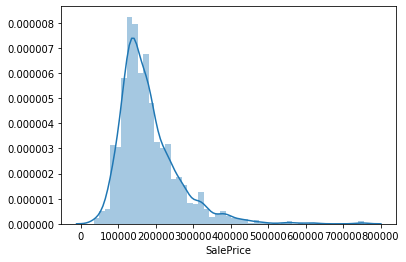

In [7]:
sns.distplot(y)

The distribution of sale prices is right skewed, with maximum values 7-8 times the median.

## High Level Description [Return](#ToC)<a id='Statistics'></a>

In [8]:
common_descriptors(X)

Head of dataframe
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
1         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
2         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
3         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
4         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      2

From this we can conclude:

- There is an almost even mixture of numeric and categorical columns (37 vs 42 respectively)

- There are lots of columns with missing values, but for some this may be systematic. For example there are columns about garages or basements that have the same proportion of missing values, so it is very likely the houses for these don't have these features, which are encoded as nan's. The same is true for the columns with a higher proportion of missing values.

- For the categorical values, there is a mixture of ordinal and nominal variables

The next section outline a systematic way to evaluating all of the features in the dataset:

- Features are grouped into sections

- Their distributions are plotted

- Statistical tests are performed to look for associations between the feature and the Sale Price of a house

- The test statistics for each feature are saved in a dictionary for later analysis

## Zoning [Return](#ToC)<a id='Zoning'></a>

Head of dataframe
   MSSubClass MSZoning
0          60       RL
1          20       RL
2          60       RL
3          70       RL
4          60       RL

 Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   MSSubClass  1460 non-null   int64 
 1   MSZoning    1460 non-null   object
dtypes: int64(1), object(1)
memory usage: 22.9+ KB
None

 Numeric Statistics
        MSSubClass
count  1460.000000
mean     56.897260
std      42.300571
min      20.000000
25%      20.000000
50%      50.000000
75%      70.000000
max     190.000000

 Nan information
MSZoning      0.0
MSSubClass    0.0
dtype: float64
 Column MSSubClass analysis
Check for strength of linear relation via Pearsons r test
(-0.0842841351265952, 0.0012664716847503312)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.007192252911733476, pvalue=0.

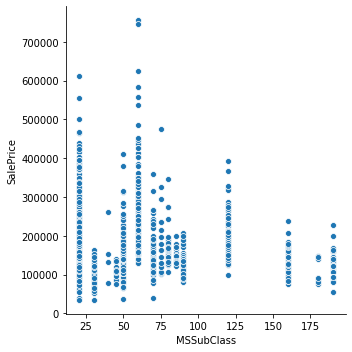

 Column MSZoning analysis
count categories
     index  MSZoning
0       RL      1151
1       RM       218
2       FV        65
3       RH        16
4  C (all)        10
Check for normality within data via Shapiro-Wilk
RL: + (0.8609548807144165, 1.0310478182418316e-30)
RM: + (0.7379856109619141, 2.6919397759553147e-18)
C (all): + (0.9390074610710144, 0.5420225262641907)
FV: + (0.9200277328491211, 0.000447796075604856)
RH: + (0.9629672765731812, 0.7158137559890747)
Check for equal variance between categories via Leven test
LeveneResult(statistic=12.30564637051124, pvalue=7.635311806308107e-10)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=270.0701971937021, pvalue=3.0807239995999556e-57)


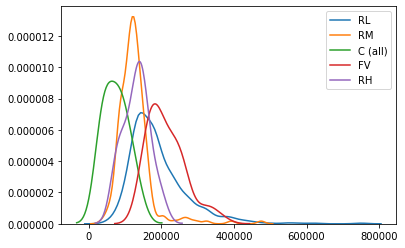

In [9]:
indexes = [1, 2]
X_zoning = X.iloc[:, indexes]
common_descriptors(X_zoning)
numerical_description(X_zoning.select_dtypes(exclude = 'object'), y, numerical_test_stats)
categorical_description(X_zoning.select_dtypes(include = 'object'), y, categorical_test_stats)

MSSublcass is categorical in nature, encode column and re-run tests.

 Column MSSubClass analysis
count categories
    index  MSSubClass
0      20         536
1      60         299
2      50         144
3     120          87
4      30          69
5     160          63
6      70          60
7      80          58
8      90          52
9     190          30
10     85          20
11     75          16
12     45          12
13    180          10
14     40           4
Check for normality within data via Shapiro-Wilk
60: + (0.7758501172065735, 6.139067611374052e-20)
20: + (0.8669025897979736, 5.9204624355076836e-21)
70: + (0.9449490904808044, 0.009074402041733265)
50: + (0.81390380859375, 3.0434708572779634e-12)
190: + (0.9674500226974487, 0.47196638584136963)
45: + (0.9623830318450928, 0.8172342777252197)
90: + (0.95382159948349, 0.0423646941781044)
120: + (0.931469202041626, 0.0001849556138040498)
30: + (0.9875223636627197, 0.7253652215003967)
85: + (0.890807032585144, 0.027827277779579163)
80: + (0.7792640924453735, 6.215419290356294e-08)
160: + (0.964524090

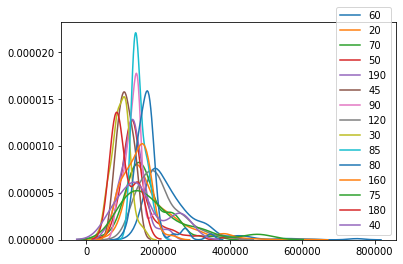

 Column MSZoning analysis
count categories
     index  MSZoning
0       RL      1151
1       RM       218
2       FV        65
3       RH        16
4  C (all)        10
Check for normality within data via Shapiro-Wilk
RL: + (0.8609548807144165, 1.0310478182418316e-30)
RM: + (0.7379856109619141, 2.6919397759553147e-18)
C (all): + (0.9390074610710144, 0.5420225262641907)
FV: + (0.9200277328491211, 0.000447796075604856)
RH: + (0.9629672765731812, 0.7158137559890747)
Check for equal variance between categories via Leven test
LeveneResult(statistic=12.30564637051124, pvalue=7.635311806308107e-10)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=270.0701971937021, pvalue=3.0807239995999556e-57)


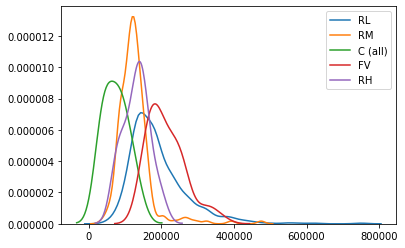

In [10]:
numerical_test_stats.pop('MSSubClass', None)
X['MSSubClass'] = X['MSSubClass'].astype('object')
X_zoning = X.iloc[:, indexes]
categorical_description(X_zoning.select_dtypes(include = 'object'), y, categorical_test_stats)

## Neighbourhood [Return](#ToC)<a id='Neighbourhood'></a>

Head of dataframe
  Neighborhood
0      CollgCr
1      Veenker
2      CollgCr
3      Crawfor
4      NoRidge

 Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Neighborhood  1460 non-null   object
dtypes: object(1)
memory usage: 11.5+ KB
None

 Numeric Statistics
       Neighborhood
count          1460
unique           25
top           NAmes
freq            225

 Nan information
Neighborhood    0.0
dtype: float64
 Column Neighborhood analysis
count categories
      index  Neighborhood
0     NAmes           225
1   CollgCr           150
2   OldTown           113
3   Edwards           100
4   Somerst            86
5   Gilbert            79
6   NridgHt            77
7    Sawyer            74
8    NWAmes            73
9   SawyerW            59
10  BrkSide            58
11  Crawfor            51
12  Mitchel            49
13  NoRidge    

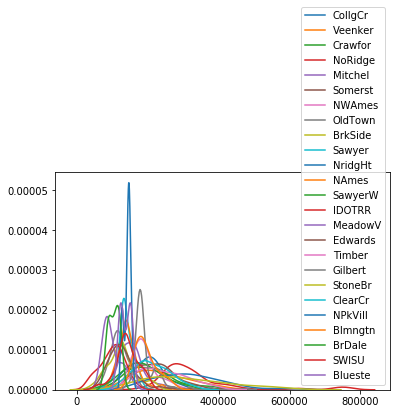

In [11]:
indexes = [12]
X_neighbourhood = X.iloc[:, indexes]
common_descriptors(X_neighbourhood)
numerical_description(X_neighbourhood.select_dtypes(exclude = 'object'), y, numerical_test_stats)
categorical_description(X_neighbourhood.select_dtypes(include = 'object'), y, categorical_test_stats)

## Outside [Return](#ToC)<a id='Outside'></a>

Head of dataframe
   LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig  \
0         65.0     8450   Pave   NaN      Reg         Lvl    AllPub    Inside   
1         80.0     9600   Pave   NaN      Reg         Lvl    AllPub       FR2   
2         68.0    11250   Pave   NaN      IR1         Lvl    AllPub    Inside   
3         60.0     9550   Pave   NaN      IR1         Lvl    AllPub    Corner   
4         84.0    14260   Pave   NaN      IR1         Lvl    AllPub       FR2   

  LandSlope  
0       Gtl  
1       Gtl  
2       Gtl  
3       Gtl  
4       Gtl  

 Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1201 non-null   float64
 1   LotArea      1460 non-null   int64  
 2   Street       1460 non-null   object 
 3   Alley        91 non-null     object 
 4   LotShape     1460 non-null   objec

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


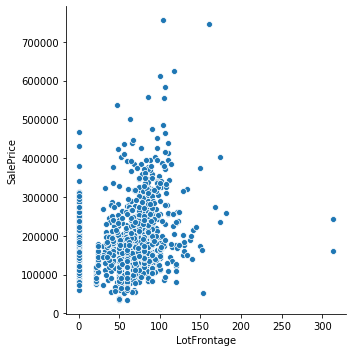

 Column LotArea analysis
Check for strength of linear relation via Pearsons r test
(0.2638433538714057, 1.1231391549193063e-24)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.4564605833912115, pvalue=4.8715809571702074e-76)


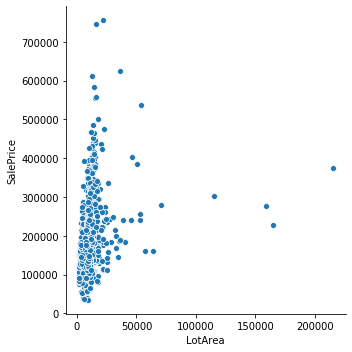

 Column Street analysis
count categories
  index  Street
0  Pave    1454
1  Grvl       6
Check for normality within data via Shapiro-Wilk
Pave: + (0.8689469695091248, 3.107200747917861e-33)
Grvl: + (0.9366073608398438, 0.6320003271102905)
Check for equal variance between categories via Leven test
LeveneResult(statistic=0.09831115095131875, pvalue=0.753910659281116)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=3.0623530770349503, pvalue=0.08012555757743882)


C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


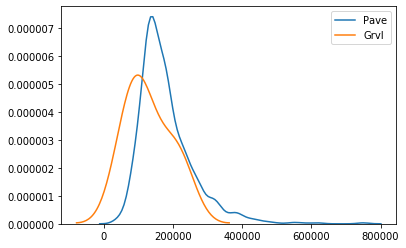

 Column Alley analysis
count categories
  index  Alley
0  None   1369
1  Grvl     50
2  Pave     41
Check for normality within data via Shapiro-Wilk
None: + (0.8711435794830322, 3.715154597751243e-32)
Grvl: + (0.937853991985321, 0.011090435087680817)
Pave: + (0.9423445463180542, 0.037850867956876755)
Check for equal variance between categories via Leven test
LeveneResult(statistic=11.906383402157658, pvalue=7.428894175227817e-06)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=45.713809901041174, pvalue=1.184056173794853e-10)


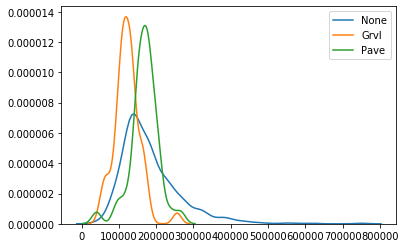

 Column LotShape analysis
count categories
  index  LotShape
0   Reg       925
1   IR1       484
2   IR2        41
3   IR3        10
Check for normality within data via Shapiro-Wilk
Reg: + (0.8716392517089844, 6.945240032014651e-27)
IR1: + (0.8553454875946045, 1.0749249218630674e-20)
IR2: + (0.8240971565246582, 1.8370732504990883e-05)
IR3: + (0.9684394598007202, 0.8760108947753906)
Check for equal variance between categories via Leven test
LeveneResult(statistic=4.44366396325219, pvalue=0.004078333512843478)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=150.9541727114474, pvalue=1.640323273843454e-32)


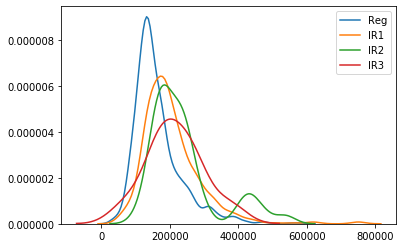

 Column LandContour analysis
count categories
  index  LandContour
0   Lvl         1311
1   Bnk           63
2   HLS           50
3   Low           36
Check for normality within data via Shapiro-Wilk
Lvl: + (0.8599444627761841, 1.2759249147366974e-32)
Bnk: + (0.9674410820007324, 0.09364726394414902)
Low: + (0.979179859161377, 0.7177106142044067)
HLS: + (0.9384773373603821, 0.011733166873455048)
Check for equal variance between categories via Leven test
LeveneResult(statistic=5.662780921694269, pvalue=0.0007424882539117275)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=35.30955225871714, pvalue=1.0479232964712046e-07)


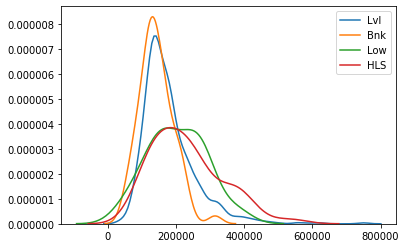

 Column Utilities analysis
count categories
    index  Utilities
0  AllPub       1459
1  NoSeWa          1
Check for normality within data via Shapiro-Wilk
AllPub: + (0.8698163628578186, 3.391828705212231e-33)
Check for equal variance between categories via Leven test
LeveneResult(statistic=0.8692149150672227, pvalue=0.3513271022456641)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=0.4073689216083271, pvalue=0.5233079667064577)


C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


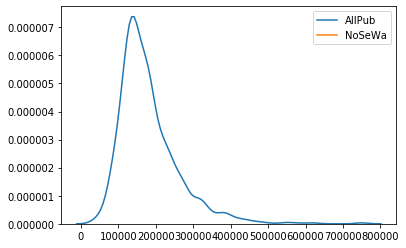

 Column LotConfig analysis
count categories
     index  LotConfig
0   Inside       1052
1   Corner        263
2  CulDSac         94
3      FR2         47
4      FR3          4
Check for normality within data via Shapiro-Wilk
Inside: + (0.88747239112854, 5.57733365194604e-27)
FR2: + (0.8989538550376892, 0.0006670355796813965)
Corner: + (0.7987708449363708, 9.96228288336101e-18)
CulDSac: + (0.8367316126823425, 8.653961103277652e-09)
FR3: + (0.9505950212478638, 0.7198346257209778)
Check for equal variance between categories via Leven test
LeveneResult(statistic=1.015716970237252, pvalue=0.39794758913754896)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=35.72390578237894, pvalue=3.297912123318503e-07)


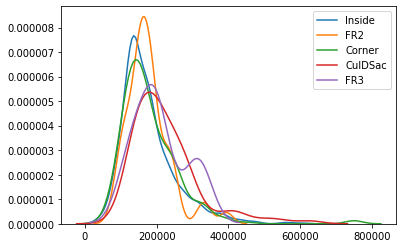

 Column LandSlope analysis
count categories
  index  LandSlope
0   Gtl       1382
1   Mod         65
2   Sev         13
Check for normality within data via Shapiro-Wilk
Gtl: + (0.862254798412323, 3.706794334991401e-33)
Mod: + (0.9460520148277283, 0.006774888373911381)
Sev: + (0.9866646528244019, 0.9977295398712158)
Check for equal variance between categories via Leven test
LeveneResult(statistic=2.5965171484835285, pvalue=0.07487757253094682)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=3.9388371382859146, pvalue=0.1395379643115706)


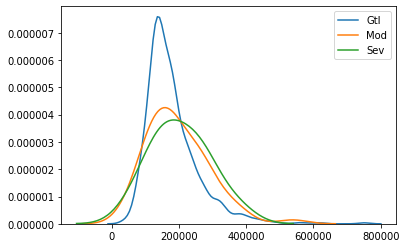

In [12]:
indexes = list(np.arange(3, 12))
X_outside = X.iloc[:, indexes]
common_descriptors(X_outside)
numerical_description(X_outside.select_dtypes(exclude = 'object'), y, numerical_test_stats)
categorical_description(X_outside.select_dtypes(include = 'object'), y, categorical_test_stats)

## House Exterior [Return](#ToC)<a id='Exterior'></a>

Head of dataframe
  Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  \
0       Norm       Norm     1Fam     2Story            7            5   
1      Feedr       Norm     1Fam     1Story            6            8   
2       Norm       Norm     1Fam     2Story            7            5   
3       Norm       Norm     1Fam     2Story            7            5   
4       Norm       Norm     1Fam     2Story            8            5   

   YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
0       2003          2003     Gable  CompShg     VinylSd     VinylSd   
1       1976          1976     Gable  CompShg     MetalSd     MetalSd   
2       2001          2002     Gable  CompShg     VinylSd     VinylSd   
3       1915          1970     Gable  CompShg     Wd Sdng     Wd Shng   
4       2000          2000     Gable  CompShg     VinylSd     VinylSd   

  MasVnrType  MasVnrArea ExterQual ExterCond  
0    BrkFace       196.0        Gd        TA  
1       No

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


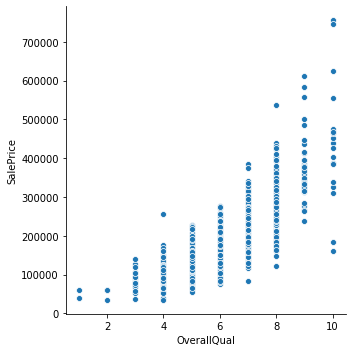

 Column OverallCond analysis
Check for strength of linear relation via Pearsons r test
(-0.07785589404867801, 0.0029123512679174826)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=-0.12932494660061317, pvalue=7.118552262128728e-07)


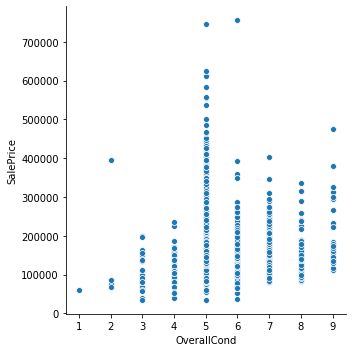

 Column YearBuilt analysis
Check for strength of linear relation via Pearsons r test
(0.5228973328794968, 2.9902290990158995e-103)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.6526815462850586, pvalue=5.693840951687133e-178)


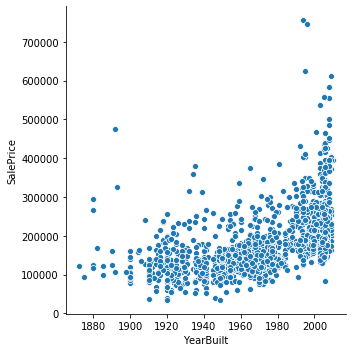

 Column YearRemodAdd analysis
Check for strength of linear relation via Pearsons r test
(0.5071009671113862, 3.1649482419200737e-96)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.5711589780582343, pvalue=3.557233443898463e-127)


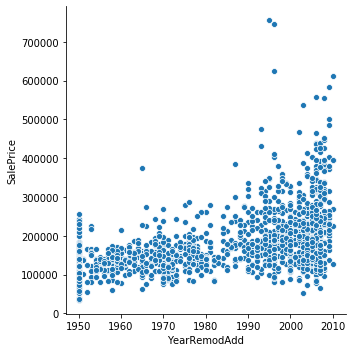

 Column MasVnrArea analysis
Check for strength of linear relation via Pearsons r test
(0.47261449900457375, 4.100461044539401e-82)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.4159061267067718, pvalue=3.7115496892405996e-62)


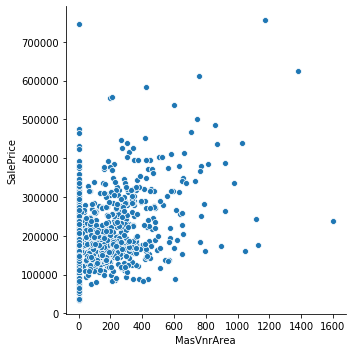

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


 Column Condition1 analysis
count categories
    index  Condition1
0    Norm        1260
1   Feedr          81
2  Artery          48
3    RRAn          26
4    PosN          19
5    RRAe          11
6    PosA           8
7    RRNn           5
8    RRNe           2
Check for normality within data via Shapiro-Wilk
Norm: + (0.8711593747138977, 5.338361832959917e-31)
Feedr: + (0.9787794947624207, 0.19850407540798187)
PosN: + (0.9400104284286499, 0.26380839943885803)
Artery: + (0.6432752013206482, 1.503276059189318e-09)
RRAe: + (0.9474453330039978, 0.611503005027771)
RRNn: + (0.9066603183746338, 0.44778352975845337)
RRAn: + (0.822719156742096, 0.0004398119926918298)
PosA: + (0.8275032639503479, 0.05591727793216705)
Check for equal variance between categories via Leven test
LeveneResult(statistic=3.6624995627598076, pvalue=0.00030850992286069964)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=74.40386260303787, pvalue=6.492599567606712e-13)


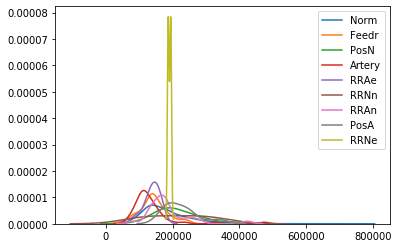

 Column Condition2 analysis
count categories
    index  Condition2
0    Norm        1445
1   Feedr           6
2    RRNn           2
3    PosN           2
4  Artery           2
5    RRAn           1
6    RRAe           1
7    PosA           1
Check for normality within data via Shapiro-Wilk
Norm: + (0.8693142533302307, 4.1534230462443445e-33)
Feedr: + (0.9241710901260376, 0.5358970165252686)


C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Check for equal variance between categories via Leven test
LeveneResult(statistic=0.9911094028537184, pvalue=0.43587336964141465)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=17.774158345863214, pvalue=0.013031585671629023)


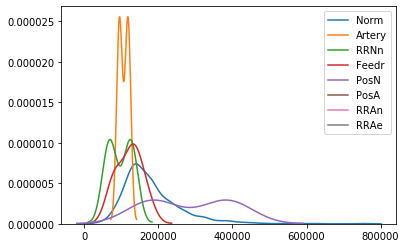

 Column BldgType analysis
count categories
    index  BldgType
0    1Fam      1220
1  TwnhsE       114
2  Duplex        52
3   Twnhs        43
4  2fmCon        31
Check for normality within data via Shapiro-Wilk
1Fam: + (0.8733966946601868, 2.4430361159241325e-30)
2fmCon: + (0.9664979577064514, 0.4282044470310211)
Duplex: + (0.95382159948349, 0.0423646941781044)
TwnhsE: + (0.936627984046936, 4.027442628284916e-05)
Twnhs: + (0.947563648223877, 0.048596207052469254)
Check for equal variance between categories via Leven test
LeveneResult(statistic=9.538030564756127, pvalue=1.300562717944124e-07)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=69.80060637424272, pvalue=2.500857956442707e-14)


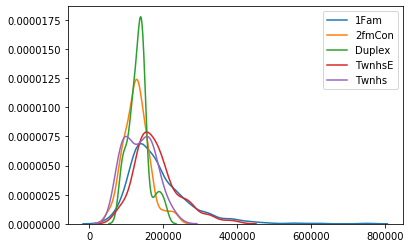

 Column HouseStyle analysis
count categories
    index  HouseStyle
0  1Story         726
1  2Story         445
2  1.5Fin         154
3    SLvl          65
4  SFoyer          37
5  1.5Unf          14
6  2.5Unf          11
7  2.5Fin           8
Check for normality within data via Shapiro-Wilk
2Story: + (0.8537942171096802, 6.274701967378021e-20)
1Story: + (0.8904154896736145, 2.7480460620401356e-22)
1.5Fin: + (0.8266242742538452, 3.1732129944506138e-12)
1.5Unf: + (0.9713708758354187, 0.8944436311721802)
SFoyer: + (0.9410656094551086, 0.04987235367298126)
SLvl: + (0.8109673857688904, 1.0846463993630096e-07)
2.5Unf: + (0.7658605575561523, 0.0033503484446555376)
2.5Fin: + (0.8259049654006958, 0.05381006374955177)
Check for equal variance between categories via Leven test
LeveneResult(statistic=7.689885473836491, pvalue=3.7991368187056394e-09)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=185.4294262425404, pvalue=1.3885066980297387e-36)


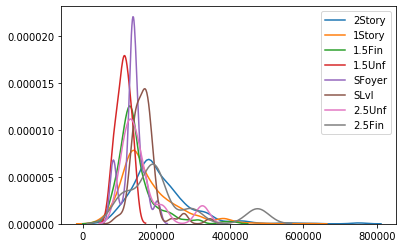

 Column RoofStyle analysis
count categories
     index  RoofStyle
0    Gable       1141
1      Hip        286
2     Flat         13
3  Gambrel         11
4  Mansard          7
5     Shed          2
Check for normality within data via Shapiro-Wilk
Gable: + (0.9095364809036255, 1.7445079599235404e-25)
Hip: + (0.8709692358970642, 9.179794104767838e-15)
Gambrel: + (0.9820091128349304, 0.9762932062149048)
Mansard: + (0.969092071056366, 0.8918325304985046)
Flat: + (0.9295111894607544, 0.3358369767665863)
Check for equal variance between categories via Leven test
LeveneResult(statistic=16.958872967769327, pvalue=2.516820635079942e-16)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=39.877540702625915, pvalue=1.5807327219164252e-07)


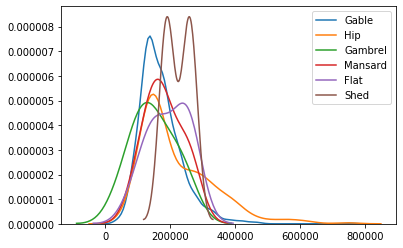

 Column RoofMatl analysis
count categories
     index  RoofMatl
0  CompShg      1434
1  Tar&Grv        11
2  WdShngl         6
3  WdShake         5
4    Metal         1
5  ClyTile         1
6     Roll         1
7  Membran         1
Check for normality within data via Shapiro-Wilk
CompShg: + (0.8792201280593872, 5.633100584507694e-32)
WdShngl: + (0.91078120470047, 0.4415561258792877)
WdShake: + (0.9932736158370972, 0.9898093342781067)
Tar&Grv: + (0.9243503212928772, 0.3565540313720703)
Check for equal variance between categories via Leven test

C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)



LeveneResult(statistic=2.8844000320732954, pvalue=0.00538652757885894)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=18.87213603664324, pvalue=0.008597464371448)


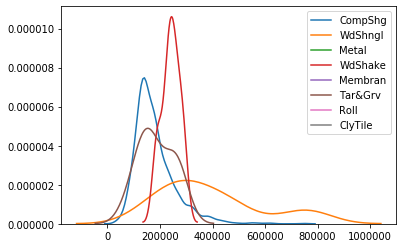

 Column Exterior1st analysis
count categories
      index  Exterior1st
0   VinylSd          515
1   HdBoard          222
2   MetalSd          220
3   Wd Sdng          206
4   Plywood          108
5   CemntBd           61
6   BrkFace           50
7   WdShing           26
8    Stucco           25
9   AsbShng           20
10    Stone            2
11  BrkComm            2
12  ImStucc            1
13  AsphShn            1
14   CBlock            1
Check for normality within data via Shapiro-Wilk
VinylSd: + (0.9216294884681702, 1.0119440152167266e-15)
MetalSd: + (0.8395340442657471, 2.464731706491169e-14)
Wd Sdng: + (0.7335225343704224, 6.4046100880434085e-18)
HdBoard: + (0.6325376629829407, 1.3744847860177735e-21)
BrkFace: + (0.9422571063041687, 0.01656363159418106)
WdShing: + (0.7151259779930115, 8.599798093200661e-06)
CemntBd: + (0.9391247034072876, 0.00452191848307848)
Plywood: + (0.9405689835548401, 0.00011348184489179403)
AsbShng: + (0.9734386801719666, 0.8251720070838928)
Stucco: + (0.

C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Check for equal variance between categories via Leven test
LeveneResult(statistic=7.789927751872381, pvalue=4.0196245951517317e-16)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=304.04457609774585, pvalue=1.694485653395439e-56)


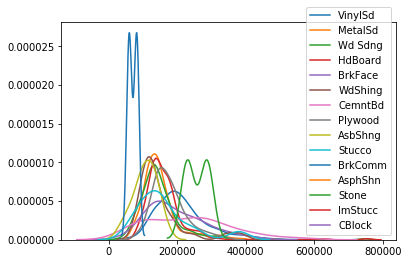

 Column Exterior2nd analysis
count categories
      index  Exterior2nd
0   VinylSd          504
1   MetalSd          214
2   HdBoard          207
3   Wd Sdng          197
4   Plywood          142
5   CmentBd           60
6   Wd Shng           38
7    Stucco           26
8   BrkFace           25
9   AsbShng           20
10  ImStucc           10
11  Brk Cmn            7
12    Stone            5
13  AsphShn            3
14   CBlock            1
15    Other            1
Check for normality within data via Shapiro-Wilk
VinylSd: + (0.9211825132369995, 1.4050970046627703e-15)
MetalSd: + (0.8348211050033569, 2.4532852420551532e-14)
Wd Shng: + (0.700299859046936, 1.667151963147262e-07)
HdBoard: + (0.6615774631500244, 4.192271220984079e-20)
Plywood: + (0.9585776329040527, 0.00028114201268181205)
Wd Sdng: + (0.8599286079406738, 1.7249890751913632e-12)
CmentBd: + (0.9442600011825562, 0.008438358083367348)
BrkFace: + (0.9331439733505249, 0.1027388870716095)
Stucco: + (0.909137487411499, 0.025190619

C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Check for equal variance between categories via Leven test
LeveneResult(statistic=7.947056301400641, pvalue=1.716931149046549e-17)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=284.2311433962902, pvalue=1.0476359663623384e-51)


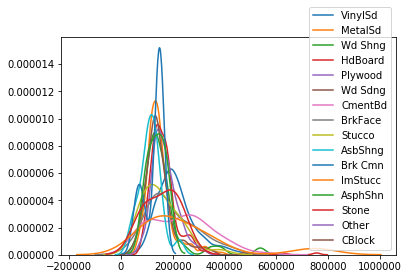

 Column MasVnrType analysis
count categories
     index  MasVnrType
0     None         872
1  BrkFace         445
2    Stone         128
3   BrkCmn          15
Check for normality within data via Shapiro-Wilk
BrkFace: + (0.8672562837600708, 5.083826195356766e-19)
None: + (0.8769137263298035, 1.1217031380681667e-25)
Stone: + (0.9230765104293823, 1.889590976134059e-06)
BrkCmn: + (0.8664650917053223, 0.02995116449892521)
Check for equal variance between categories via Leven test
LeveneResult(statistic=17.76200958740005, pvalue=2.519871359614478e-11)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=270.81288111361283, pvalue=2.0587312313534828e-58)


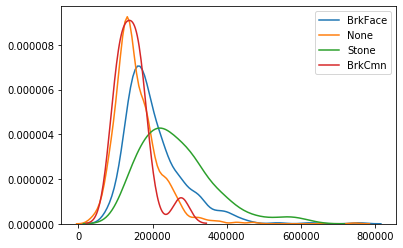

 Column ExterQual analysis
count categories
  index  ExterQual
0    TA        906
1    Gd        488
2    Ex         52
3    Fa         14
Check for normality within data via Shapiro-Wilk
Gd: + (0.8948691487312317, 8.732056862980294e-18)
TA: + (0.9416452646255493, 2.1391535841499087e-18)
Ex: + (0.9576833844184875, 0.06212182343006134)
Fa: + (0.8484312295913696, 0.02114863693714142)
Check for equal variance between categories via Leven test
LeveneResult(statistic=51.64722405915516, pvalue=1.012595529134994e-31)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=683.4400843408405, pvalue=8.180798192071324e-148)


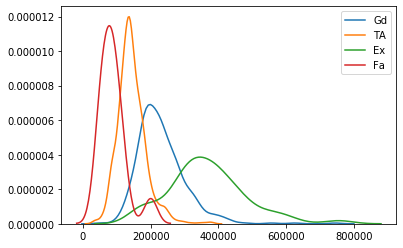

 Column ExterCond analysis
count categories
  index  ExterCond
0    TA       1282
1    Gd        146
2    Fa         28
3    Ex          3
4    Po          1
Check for normality within data via Shapiro-Wilk
TA: + (0.8728228807449341, 4.494635716329529e-31)
Gd: + (0.7797657251358032, 1.5430541501666728e-13)
Fa: + (0.9384658336639404, 0.10103495419025421)
Check for equal variance between categories via Leven test
LeveneResult(statistic=2.1554311359023552, pvalue=0.07184968303623517)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=46.61696786384183, pvalue=1.8323647163959772e-09)


C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


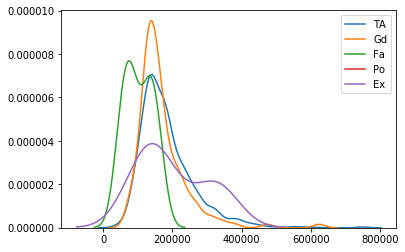

In [13]:
indexes = list(np.arange(13, 29))
X_exterior = X.iloc[:, indexes]
common_descriptors(X_exterior)
numerical_description(X_exterior.select_dtypes(exclude = 'object'), y, numerical_test_stats)
categorical_description(X_exterior.select_dtypes(include = 'object'), y, categorical_test_stats)

OverallQual and OverallCond are categorical in nature; encode column and re-run tests.

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


 Column Condition1 analysis
count categories
    index  Condition1
0    Norm        1260
1   Feedr          81
2  Artery          48
3    RRAn          26
4    PosN          19
5    RRAe          11
6    PosA           8
7    RRNn           5
8    RRNe           2
Check for normality within data via Shapiro-Wilk
Norm: + (0.8711593747138977, 5.338361832959917e-31)
Feedr: + (0.9787794947624207, 0.19850407540798187)
PosN: + (0.9400104284286499, 0.26380839943885803)
Artery: + (0.6432752013206482, 1.503276059189318e-09)
RRAe: + (0.9474453330039978, 0.611503005027771)
RRNn: + (0.9066603183746338, 0.44778352975845337)
RRAn: + (0.822719156742096, 0.0004398119926918298)
PosA: + (0.8275032639503479, 0.05591727793216705)
Check for equal variance between categories via Leven test
LeveneResult(statistic=3.6624995627598076, pvalue=0.00030850992286069964)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=74.40386260303787, pvalue=6.492599567606712e-13)


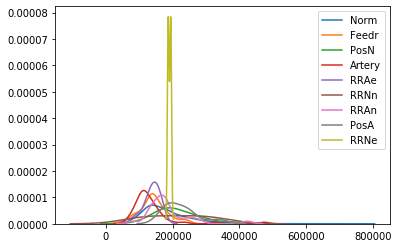

 Column Condition2 analysis
count categories
    index  Condition2
0    Norm        1445
1   Feedr           6
2    RRNn           2
3    PosN           2
4  Artery           2
5    RRAn           1
6    RRAe           1
7    PosA           1
Check for normality within data via Shapiro-Wilk
Norm: + (0.8693142533302307, 4.1534230462443445e-33)
Feedr: + (0.9241710901260376, 0.5358970165252686)
Check for equal variance between categories via Leven test
LeveneResult(statistic=0.9911094028537184, pvalue=0.43587336964141465)
Calculate Kruskal Wallis test statistic


C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


KruskalResult(statistic=17.774158345863214, pvalue=0.013031585671629023)


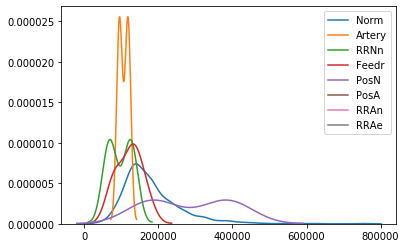

 Column BldgType analysis
count categories
    index  BldgType
0    1Fam      1220
1  TwnhsE       114
2  Duplex        52
3   Twnhs        43
4  2fmCon        31
Check for normality within data via Shapiro-Wilk
1Fam: + (0.8733966946601868, 2.4430361159241325e-30)
2fmCon: + (0.9664979577064514, 0.4282044470310211)
Duplex: + (0.95382159948349, 0.0423646941781044)
TwnhsE: + (0.936627984046936, 4.027442628284916e-05)
Twnhs: + (0.947563648223877, 0.048596207052469254)
Check for equal variance between categories via Leven test
LeveneResult(statistic=9.538030564756127, pvalue=1.300562717944124e-07)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=69.80060637424272, pvalue=2.500857956442707e-14)


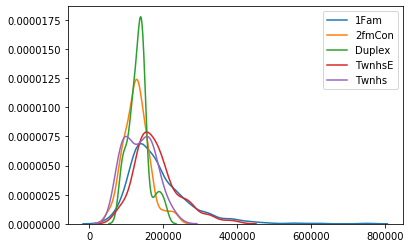

 Column HouseStyle analysis
count categories
    index  HouseStyle
0  1Story         726
1  2Story         445
2  1.5Fin         154
3    SLvl          65
4  SFoyer          37
5  1.5Unf          14
6  2.5Unf          11
7  2.5Fin           8
Check for normality within data via Shapiro-Wilk
2Story: + (0.8537942171096802, 6.274701967378021e-20)
1Story: + (0.8904154896736145, 2.7480460620401356e-22)
1.5Fin: + (0.8266242742538452, 3.1732129944506138e-12)
1.5Unf: + (0.9713708758354187, 0.8944436311721802)
SFoyer: + (0.9410656094551086, 0.04987235367298126)
SLvl: + (0.8109673857688904, 1.0846463993630096e-07)
2.5Unf: + (0.7658605575561523, 0.0033503484446555376)
2.5Fin: + (0.8259049654006958, 0.05381006374955177)
Check for equal variance between categories via Leven test
LeveneResult(statistic=7.689885473836491, pvalue=3.7991368187056394e-09)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=185.4294262425404, pvalue=1.3885066980297387e-36)


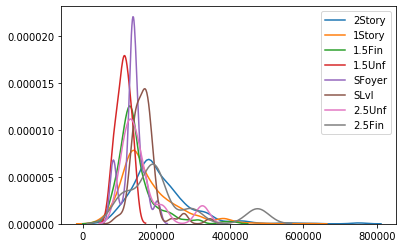

 Column OverallQual analysis
count categories
   index  OverallQual
0      5          397
1      6          374
2      7          319
3      8          168
4      4          116
5      9           43
6      3           20
7     10           18
8      2            3
9      1            2
Check for normality within data via Shapiro-Wilk
7: + (0.966026782989502, 8.415378260906436e-07)
6: + (0.9877444505691528, 0.003053551074117422)
8: + (0.9669694304466248, 0.0004966172855347395)
5: + (0.9808617234230042, 4.1298510041087866e-05)
9: + (0.879179835319519, 0.0003098422603216022)
4: + (0.9377783536911011, 4.103571336599998e-05)
10: + (0.9461963176727295, 0.36849913001060486)
3: + (0.9855245351791382, 0.9845577478408813)
Check for equal variance between categories via Leven test
LeveneResult(statistic=33.092965951498684, pvalue=2.8141379206288557e-53)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=966.1027730120145, pvalue=3.5069726379167716e-202)


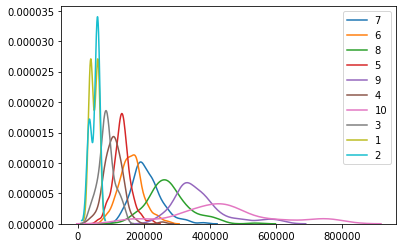

 Column OverallCond analysis
count categories
   index  OverallCond
0      5          821
1      6          252
2      7          205
3      8           72
4      4           57
5      3           25
6      9           22
7      2            5
8      1            1
Check for normality within data via Shapiro-Wilk
5: + (0.8965990543365479, 4.58819109851945e-23)
8: + (0.837656557559967, 2.0579109616392088e-07)
6: + (0.7120679616928101, 1.4477313465315956e-20)
7: + (0.8955903649330139, 9.14706574373092e-11)
4: + (0.9713854193687439, 0.1945522427558899)
2: + (0.6065453290939331, 0.0007652564672753215)
3: + (0.9302555918693542, 0.08809805661439896)
9: + (0.8739966750144958, 0.009298281744122505)
Check for equal variance between categories via Leven test
LeveneResult(statistic=9.471873896844398, pvalue=7.767552745837824e-13)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=238.76548656027506, pvalue=4.133949890533891e-47)


C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


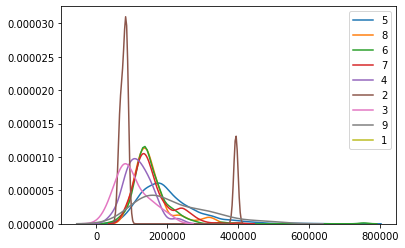

 Column RoofStyle analysis
count categories
     index  RoofStyle
0    Gable       1141
1      Hip        286
2     Flat         13
3  Gambrel         11
4  Mansard          7
5     Shed          2
Check for normality within data via Shapiro-Wilk
Gable: + (0.9095364809036255, 1.7445079599235404e-25)
Hip: + (0.8709692358970642, 9.179794104767838e-15)
Gambrel: + (0.9820091128349304, 0.9762932062149048)
Mansard: + (0.969092071056366, 0.8918325304985046)
Flat: + (0.9295111894607544, 0.3358369767665863)
Check for equal variance between categories via Leven test
LeveneResult(statistic=16.958872967769327, pvalue=2.516820635079942e-16)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=39.877540702625915, pvalue=1.5807327219164252e-07)


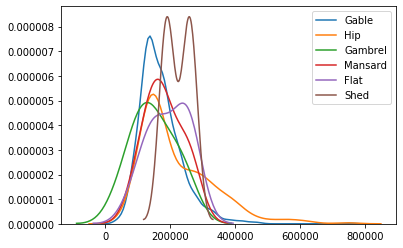

 Column RoofMatl analysis
count categories
     index  RoofMatl
0  CompShg      1434
1  Tar&Grv        11
2  WdShngl         6
3  WdShake         5
4    Metal         1
5  ClyTile         1
6     Roll         1
7  Membran         1
Check for normality within data via Shapiro-Wilk
CompShg: + (0.8792201280593872, 5.633100584507694e-32)
WdShngl: + (0.91078120470047, 0.4415561258792877)
WdShake: + (0.9932736158370972, 0.9898093342781067)
Tar&Grv: + (0.9243503212928772, 0.3565540313720703)
Check for equal variance between categories via Leven test
LeveneResult(statistic=2.8844000320732954, pvalue=0.00538652757885894)

C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)



Calculate Kruskal Wallis test statistic
KruskalResult(statistic=18.87213603664324, pvalue=0.008597464371448)


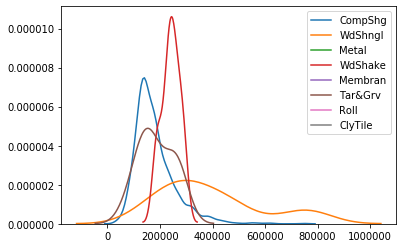

 Column Exterior1st analysis
count categories
      index  Exterior1st
0   VinylSd          515
1   HdBoard          222
2   MetalSd          220
3   Wd Sdng          206
4   Plywood          108
5   CemntBd           61
6   BrkFace           50
7   WdShing           26
8    Stucco           25
9   AsbShng           20
10    Stone            2
11  BrkComm            2
12  ImStucc            1
13  AsphShn            1
14   CBlock            1
Check for normality within data via Shapiro-Wilk
VinylSd: + (0.9216294884681702, 1.0119440152167266e-15)
MetalSd: + (0.8395340442657471, 2.464731706491169e-14)
Wd Sdng: + (0.7335225343704224, 6.4046100880434085e-18)
HdBoard: + (0.6325376629829407, 1.3744847860177735e-21)
BrkFace: + (0.9422571063041687, 0.01656363159418106)
WdShing: + (0.7151259779930115, 8.599798093200661e-06)
CemntBd: + (0.9391247034072876, 0.00452191848307848)
Plywood: + (0.9405689835548401, 0.00011348184489179403)
AsbShng: + (0.9734386801719666, 0.8251720070838928)
Stucco: + (0.

C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Check for equal variance between categories via Leven test
LeveneResult(statistic=7.789927751872381, pvalue=4.0196245951517317e-16)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=304.04457609774585, pvalue=1.694485653395439e-56)


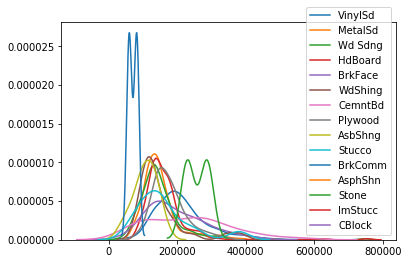

 Column Exterior2nd analysis
count categories
      index  Exterior2nd
0   VinylSd          504
1   MetalSd          214
2   HdBoard          207
3   Wd Sdng          197
4   Plywood          142
5   CmentBd           60
6   Wd Shng           38
7    Stucco           26
8   BrkFace           25
9   AsbShng           20
10  ImStucc           10
11  Brk Cmn            7
12    Stone            5
13  AsphShn            3
14   CBlock            1
15    Other            1
Check for normality within data via Shapiro-Wilk
VinylSd: + (0.9211825132369995, 1.4050970046627703e-15)
MetalSd: + (0.8348211050033569, 2.4532852420551532e-14)
Wd Shng: + (0.700299859046936, 1.667151963147262e-07)
HdBoard: + (0.6615774631500244, 4.192271220984079e-20)
Plywood: + (0.9585776329040527, 0.00028114201268181205)
Wd Sdng: + (0.8599286079406738, 1.7249890751913632e-12)
CmentBd: + (0.9442600011825562, 0.008438358083367348)
BrkFace: + (0.9331439733505249, 0.1027388870716095)
Stucco: + (0.909137487411499, 0.025190619

C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


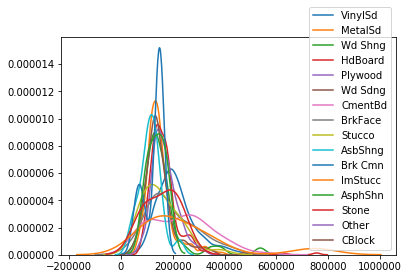

 Column MasVnrType analysis
count categories
     index  MasVnrType
0     None         872
1  BrkFace         445
2    Stone         128
3   BrkCmn          15
Check for normality within data via Shapiro-Wilk
BrkFace: + (0.8672562837600708, 5.083826195356766e-19)
None: + (0.8769137263298035, 1.1217031380681667e-25)
Stone: + (0.9230765104293823, 1.889590976134059e-06)
BrkCmn: + (0.8664650917053223, 0.02995116449892521)
Check for equal variance between categories via Leven test
LeveneResult(statistic=17.76200958740005, pvalue=2.519871359614478e-11)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=270.81288111361283, pvalue=2.0587312313534828e-58)


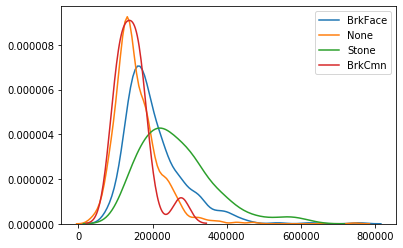

 Column ExterQual analysis
count categories
  index  ExterQual
0    TA        906
1    Gd        488
2    Ex         52
3    Fa         14
Check for normality within data via Shapiro-Wilk
Gd: + (0.8948691487312317, 8.732056862980294e-18)
TA: + (0.9416452646255493, 2.1391535841499087e-18)
Ex: + (0.9576833844184875, 0.06212182343006134)
Fa: + (0.8484312295913696, 0.02114863693714142)
Check for equal variance between categories via Leven test
LeveneResult(statistic=51.64722405915516, pvalue=1.012595529134994e-31)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=683.4400843408405, pvalue=8.180798192071324e-148)


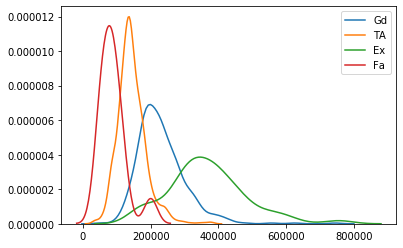

 Column ExterCond analysis
count categories
  index  ExterCond
0    TA       1282
1    Gd        146
2    Fa         28
3    Ex          3
4    Po          1
Check for normality within data via Shapiro-Wilk
TA: + (0.8728228807449341, 4.494635716329529e-31)
Gd: + (0.7797657251358032, 1.5430541501666728e-13)
Fa: + (0.9384658336639404, 0.10103495419025421)
Check for equal variance between categories via Leven test
LeveneResult(statistic=2.1554311359023552, pvalue=0.07184968303623517)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=46.61696786384183, pvalue=1.8323647163959772e-09)


C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


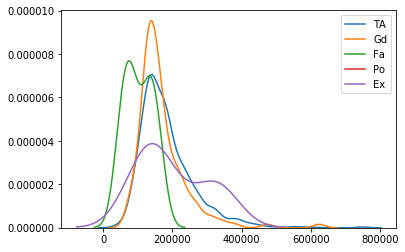

In [14]:
numerical_test_stats.pop('OverallQual', None)
numerical_test_stats.pop('OverallCond', None)

X['OverallQual'] = X['OverallQual'].astype('object')
X['OverallCond'] = X['OverallCond'].astype('object')
X_exterior = X.iloc[:, indexes]
categorical_description(X_exterior.select_dtypes(include = 'object'), y, categorical_test_stats)

## House Basement [Return](#ToC)<a id='Basement'></a>

Head of dataframe
  Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1  \
0      PConc       Gd       TA           No          GLQ         706   
1     CBlock       Gd       TA           Gd          ALQ         978   
2      PConc       Gd       TA           Mn          GLQ         486   
3     BrkTil       TA       Gd           No          ALQ         216   
4      PConc       Gd       TA           Av          GLQ         655   

  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  
0          Unf           0        150          856  
1          Unf           0        284         1262  
2          Unf           0        434          920  
3          Unf           0        540          756  
4          Unf           0        490         1145  

 Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Foundation    1460 no

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


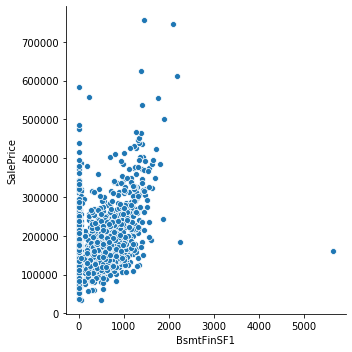

 Column BsmtFinSF2 analysis
Check for strength of linear relation via Pearsons r test
(-0.011378121450215141, 0.663998650834577)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=-0.03880613204589418, pvalue=0.13832207880728556)


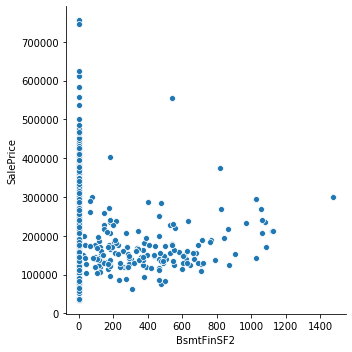

 Column BsmtUnfSF analysis
Check for strength of linear relation via Pearsons r test
(0.21447910554696892, 1.1829757963600795e-16)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.185196629420762, pvalue=9.886860550378513e-13)


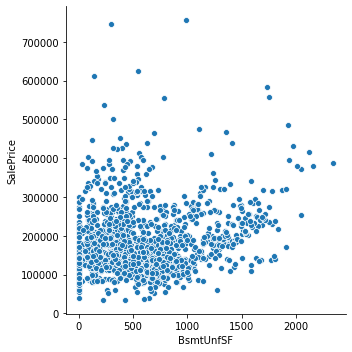

 Column TotalBsmtSF analysis
Check for strength of linear relation via Pearsons r test
(0.6135805515591954, 9.484229391507914e-152)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.6027254448924096, pvalue=4.157299803636561e-145)


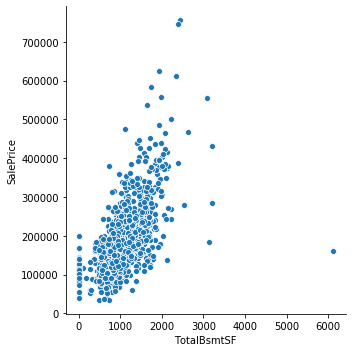

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


 Column Foundation analysis
count categories
    index  Foundation
0   PConc         647
1  CBlock         634
2  BrkTil         146
3    Slab          24
4   Stone           6
5    Wood           3
Check for normality within data via Shapiro-Wilk
PConc: + (0.8774636387825012, 3.6833528727548037e-22)
CBlock: + (0.8982100486755371, 4.3266234470385904e-20)
BrkTil: + (0.8389961123466492, 2.330121165461385e-11)
Slab: + (0.9483749270439148, 0.24978503584861755)
Stone: + (0.7449190616607666, 0.017757046967744827)
Check for equal variance between categories via Leven test
LeveneResult(statistic=21.01708137011448, pvalue=2.4718151487790666e-20)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=488.72275088132284, pvalue=2.169096402016262e-103)


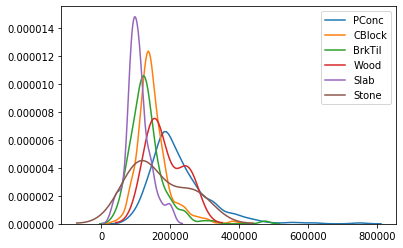

 Column BsmtQual analysis
count categories
  index  BsmtQual
0    TA       649
1    Gd       618
2    Ex       121
3  None        37
4    Fa        35
Check for normality within data via Shapiro-Wilk
Gd: + (0.9521117210388184, 2.8255913234187524e-13)
TA: + (0.8910732269287109, 5.2824630373656484e-21)
Ex: + (0.932254433631897, 1.233867442351766e-05)
None: + (0.9425587058067322, 0.055653709918260574)
Fa: + (0.9457654356956482, 0.08398473262786865)
Check for equal variance between categories via Leven test
LeveneResult(statistic=45.85439214132635, pvalue=2.541460179510898e-36)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=674.4108605109095, pvalue=1.209826097695688e-144)


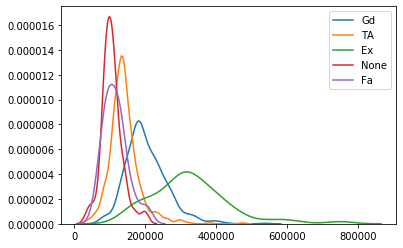

 Column BsmtCond analysis
count categories
  index  BsmtCond
0    TA      1311
1    Gd        65
2    Fa        45
3  None        37
4    Po         2
Check for normality within data via Shapiro-Wilk
TA: + (0.8599855303764343, 1.287141187958656e-32)
Gd: + (0.9152339696884155, 0.000282915192656219)
None: + (0.9425587058067322, 0.055653709918260574)
Fa: + (0.9478847980499268, 0.04226204752922058)
Check for equal variance between categories via Leven test
LeveneResult(statistic=4.994650558490932, pvalue=0.000533096723409928)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=120.87971535179602, pvalue=3.465401230987365e-25)


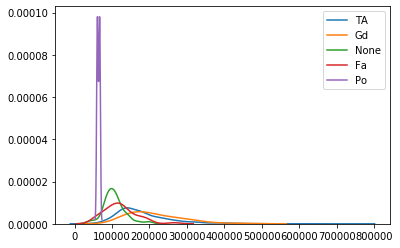

 Column BsmtExposure analysis
count categories
  index  BsmtExposure
0    No           953
1    Av           221
2    Gd           134
3    Mn           114
4  None            38
Check for normality within data via Shapiro-Wilk
No: + (0.9224989414215088, 1.0066564901797478e-21)
Gd: + (0.9015002250671387, 6.481210590436604e-08)
Mn: + (0.9285012483596802, 1.26370505313389e-05)
Av: + (0.8784344792366028, 2.5518862196982628e-12)
None: + (0.9251636266708374, 0.014165079221129417)
Check for equal variance between categories via Leven test
LeveneResult(statistic=28.17280475248493, pvalue=1.4370899380164788e-22)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=191.0297617817265, pvalue=3.184260345613763e-40)


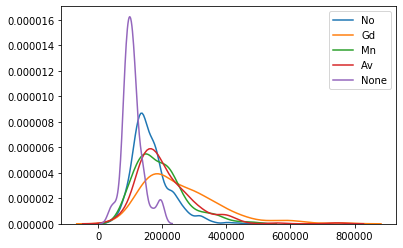

 Column BsmtFinType1 analysis
count categories
  index  BsmtFinType1
0   Unf           430
1   GLQ           418
2   ALQ           220
3   BLQ           148
4   Rec           133
5   LwQ            74
6  None            37
Check for normality within data via Shapiro-Wilk
GLQ: + (0.8829801678657532, 2.7993962450721796e-17)
ALQ: + (0.8247990012168884, 5.094314066319801e-15)
Unf: + (0.9156104326248169, 8.979679182847221e-15)
Rec: + (0.8886280059814453, 1.5157802124576847e-08)
BLQ: + (0.9155559539794922, 1.299012097888408e-07)
None: + (0.9425587058067322, 0.055653709918260574)
LwQ: + (0.8990579843521118, 2.218090412497986e-05)
Check for equal variance between categories via Leven test
LeveneResult(statistic=20.537935711557, pvalue=3.46179129193209e-23)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=348.8784404607365, pvalue=2.6868703907040177e-72)


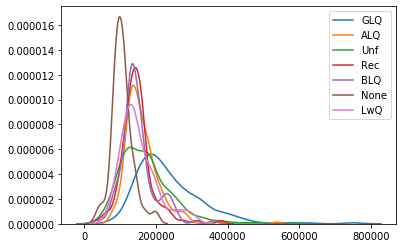

 Column BsmtFinType2 analysis
count categories
  index  BsmtFinType2
0   Unf          1256
1   Rec            54
2   LwQ            46
3  None            38
4   BLQ            33
5   ALQ            19
6   GLQ            14
Check for normality within data via Shapiro-Wilk
Unf: + (0.8737870454788208, 1.0713218533733203e-30)
BLQ: + (0.9637973308563232, 0.3297654688358307)
None: + (0.8017745614051819, 1.136332139139995e-05)
ALQ: + (0.7510492205619812, 0.00024139415472745895)
Rec: + (0.7907043099403381, 2.462314512285957e-07)
LwQ: + (0.9420776963233948, 0.023413656279444695)
GLQ: + (0.9082364439964294, 0.14855919778347015)
Check for equal variance between categories via Leven test
LeveneResult(statistic=4.932306736856734, pvalue=5.2528111992739615e-05)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=64.58938741003553, pvalue=5.232441452474992e-12)


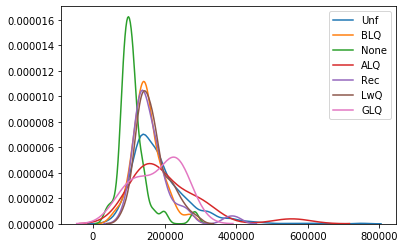

In [15]:
indexes = list(np.arange(29, 39))
X_basement = X.iloc[:, indexes]
common_descriptors(X_basement)
numerical_description(X_basement.select_dtypes(exclude = 'object'), y, numerical_test_stats)
categorical_description(X_basement.select_dtypes(include = 'object'), y, categorical_test_stats)

## House Utilities [Return](#ToC)<a id='Utilities'></a>

Head of dataframe
  Heating HeatingQC CentralAir Electrical
0    GasA        Ex          Y      SBrkr
1    GasA        Ex          Y      SBrkr
2    GasA        Ex          Y      SBrkr
3    GasA        Gd          Y      SBrkr
4    GasA        Ex          Y      SBrkr

 Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Heating     1460 non-null   object
 1   HeatingQC   1460 non-null   object
 2   CentralAir  1460 non-null   object
 3   Electrical  1459 non-null   object
dtypes: object(4)
memory usage: 45.8+ KB
None

 Numeric Statistics
       Heating HeatingQC CentralAir Electrical
count     1460      1460       1460       1459
unique       6         5          2          5
top       GasA        Ex          Y      SBrkr
freq      1428       741       1365       1334

 Nan information
Electrical    0.000685
CentralAir    0.000000
Heat

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


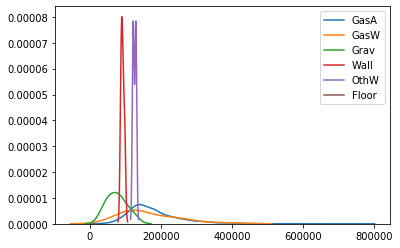

 Column HeatingQC analysis
count categories
  index  HeatingQC
0    Ex        741
1    TA        428
2    Gd        241
3    Fa         49
4    Po          1
Check for normality within data via Shapiro-Wilk
Ex: + (0.8792718648910522, 1.553437358563519e-23)
Gd: + (0.920072078704834, 4.258937091883297e-10)
TA: + (0.8980352878570557, 2.6505786442889074e-16)
Fa: + (0.972007691860199, 0.29054009914398193)
Check for equal variance between categories via Leven test

C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)



LeveneResult(statistic=25.71086052256456, pvalue=1.2947657420147596e-20)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=356.7764068321749, pvalue=6.036448505067046e-76)


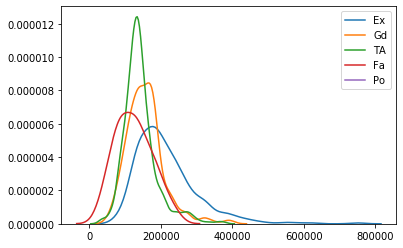

 Column CentralAir analysis
count categories
  index  CentralAir
0     Y        1365
1     N          95
Check for normality within data via Shapiro-Wilk
Y: + (0.8567324876785278, 1.703071827505677e-33)
N: + (0.9259951710700989, 4.6277895307866856e-05)
Check for equal variance between categories via Leven test
LeveneResult(statistic=16.870939800416703, pvalue=4.223227981269236e-05)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=143.19826062806808, pvalue=5.319641624535031e-33)


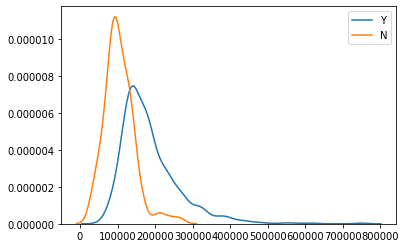

 Column Electrical analysis
count categories
   index  Electrical
0  SBrkr        1334
1  FuseA          94
2  FuseF          27
3  FuseP           3
4    Mix           1
5   None           1
Check for normality within data via Shapiro-Wilk
SBrkr: + (0.8666557669639587, 3.119428460560305e-32)
FuseF: + (0.9724048972129822, 0.6662869453430176)
FuseA: + (0.981772243976593, 0.2148224115371704)
Check for equal variance between categories via Leven test
LeveneResult(statistic=5.799795467396245, pvalue=2.6038847733230497e-05)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=131.51093489569223, pvalue=1.1373490294084296e-26)


C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


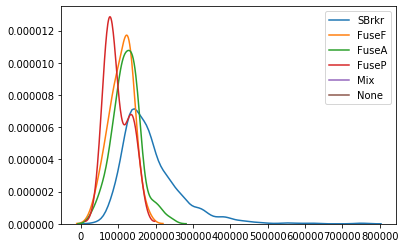

In [16]:
indexes = list(np.arange(39 ,43))
X_utilities = X.iloc[:, indexes]
common_descriptors(X_utilities)
numerical_description(X_utilities.select_dtypes(exclude = 'object'), y, numerical_test_stats)
categorical_description(X_utilities.select_dtypes(include = 'object'), y, categorical_test_stats)

## House Floorspace [Return](#ToC)<a id='Floorspace'></a>

Head of dataframe
   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0       856       854             0       1710             1             0   
1      1262         0             0       1262             0             1   
2       920       866             0       1786             1             0   
3       961       756             0       1717             1             0   
4      1145      1053             0       2198             1             0   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd  \
0         2         1             3             1          Gd             8   
1         2         0             3             1          TA             6   
2         2         1             3             1          Gd             6   
3         1         0             3             1          Gd             7   
4         2         1             4             1          Gd             9   

  Functional  Fireplaces FireplaceQu  

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


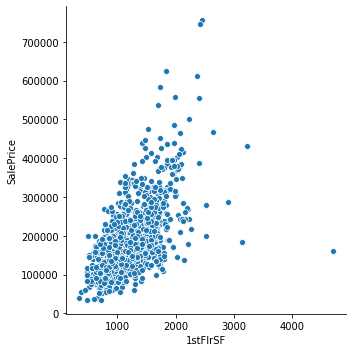

 Column 2ndFlrSF analysis
Check for strength of linear relation via Pearsons r test
(0.3193338028320678, 5.764335119183061e-36)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.29359798822238187, pvalue=2.0403436410333482e-30)


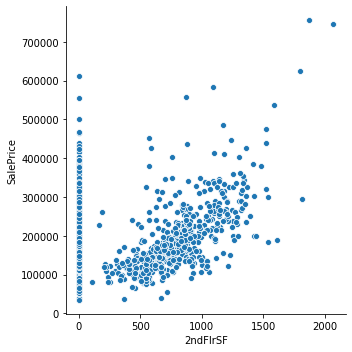

 Column LowQualFinSF analysis
Check for strength of linear relation via Pearsons r test
(-0.02560613000067956, 0.32820730984074886)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=-0.06771915407896568, pvalue=0.009645077992462557)


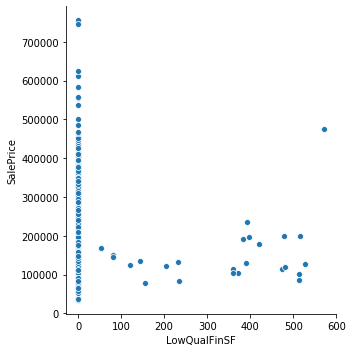

 Column GrLivArea analysis
Check for strength of linear relation via Pearsons r test
(0.708624477612652, 4.518033646780971e-223)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.7313095834659141, pvalue=1.4310154533091797e-244)


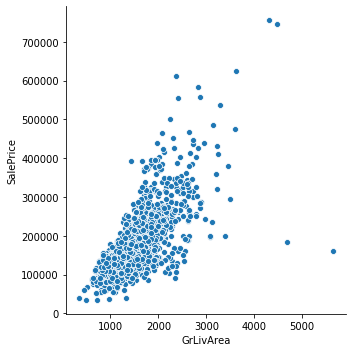

 Column BsmtFullBath analysis
Check for strength of linear relation via Pearsons r test
(0.22712223313149424, 1.550344137214128e-18)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.22512486719612368, pvalue=3.1301500762413953e-18)


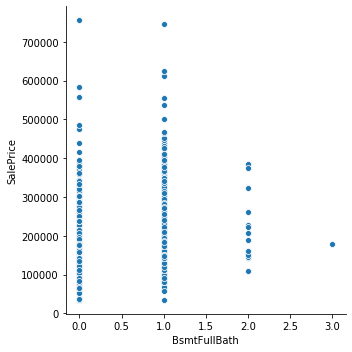

 Column BsmtHalfBath analysis
Check for strength of linear relation via Pearsons r test
(-0.016844154297359012, 0.5201536357280931)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=-0.012188876310787316, pvalue=0.6416774746324128)


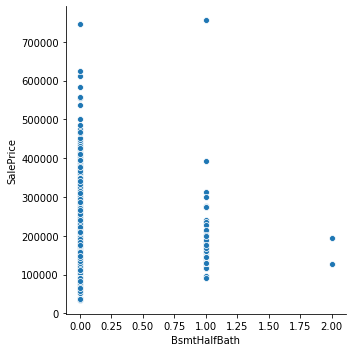

 Column FullBath analysis
Check for strength of linear relation via Pearsons r test
(0.560663762748446, 1.236470066760862e-121)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.6359570562496957, pvalue=2.7295740095874625e-166)


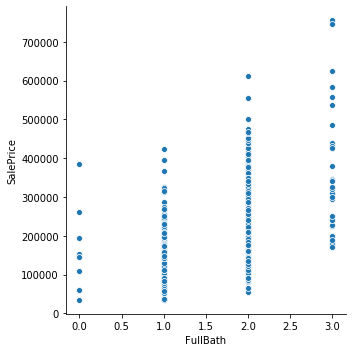

 Column HalfBath analysis
Check for strength of linear relation via Pearsons r test
(0.28410767559478256, 1.6504733955727557e-28)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.34300754918568294, pvalue=1.4229500450097462e-41)


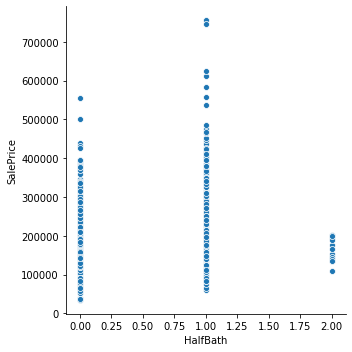

 Column BedroomAbvGr analysis
Check for strength of linear relation via Pearsons r test
(0.16821315430073996, 9.927497326187329e-11)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.23490671789027862, pvalue=9.402132344114265e-20)


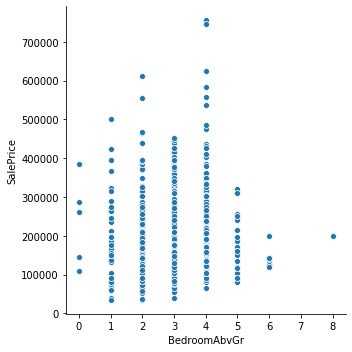

 Column KitchenAbvGr analysis
Check for strength of linear relation via Pearsons r test
(-0.1359073708421412, 1.8604260320766925e-07)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=-0.1648257549850205, pvalue=2.3585159718449775e-10)


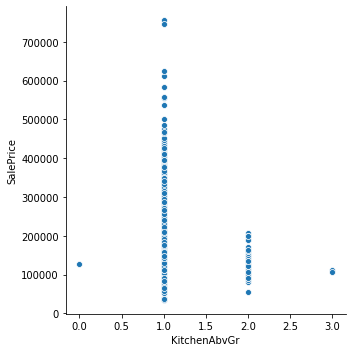

 Column TotRmsAbvGrd analysis
Check for strength of linear relation via Pearsons r test
(0.5337231555820282, 2.772280932958747e-108)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.532585935116993, pvalue=9.553211233237672e-108)


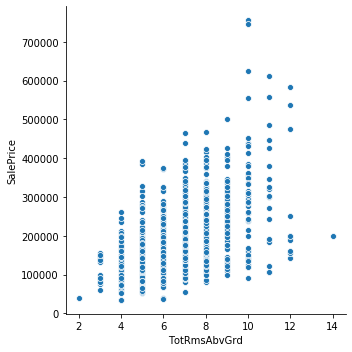

 Column Fireplaces analysis
Check for strength of linear relation via Pearsons r test
(0.46692883675152774, 6.141487461119927e-80)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.5192474498367013, pvalue=1.3546979782138591e-101)


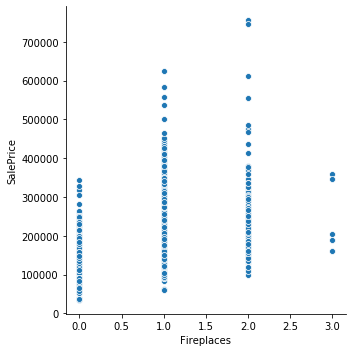

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


 Column KitchenQual analysis
count categories
  index  KitchenQual
0    TA          735
1    Gd          586
2    Ex          100
3    Fa           39
Check for normality within data via Shapiro-Wilk
Gd: + (0.9404856562614441, 1.4627472952506715e-14)
TA: + (0.9525182843208313, 1.2083440835647472e-14)
Ex: + (0.9487834572792053, 0.000690411077812314)
Fa: + (0.9658145308494568, 0.2770366072654724)
Check for equal variance between categories via Leven test
LeveneResult(statistic=75.90889354996212, pvalue=1.2792878591616223e-45)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=661.4815872916723, pvalue=4.720112898518107e-143)


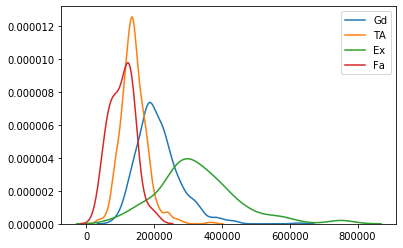

 Column Functional analysis
count categories
  index  Functional
0   Typ        1360
1  Min2          34
2  Min1          31
3   Mod          15
4  Maj1          14
5  Maj2           5
6   Sev           1
Check for normality within data via Shapiro-Wilk
Typ: + (0.873175323009491, 7.360058714361469e-32)
Min1: + (0.962878406047821, 0.346971720457077)
Maj1: + (0.8951513171195984, 0.09593456238508224)
Min2: + (0.8220970034599304, 7.065273530315608e-05)
Mod: + (0.7678675651550293, 0.001464420696720481)
Maj2: + (0.9302647709846497, 0.5981771349906921)
Check for equal variance between categories via Leven test
LeveneResult(statistic=3.2058295451467504, pvalue=0.003941556478703438)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=32.55981593513185, pvalue=1.2741797160986796e-05)


C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


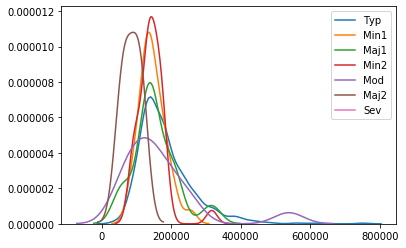

 Column FireplaceQu analysis
count categories
  index  FireplaceQu
0  None          690
1    Gd          380
2    TA          313
3    Fa           33
4    Ex           24
5    Po           20
Check for normality within data via Shapiro-Wilk
None: + (0.9651637673377991, 9.678919124511687e-12)
TA: + (0.8244742155075073, 3.75463525251444e-18)
Gd: + (0.9161105751991272, 1.0380400288249533e-13)
Fa: + (0.9357827305793762, 0.05127148702740669)
Ex: + (0.8817865252494812, 0.009029182605445385)
Po: + (0.9205381274223328, 0.10147710889577866)
Check for equal variance between categories via Leven test
LeveneResult(statistic=35.39241064192538, pvalue=2.9370412099482057e-34)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=461.8996248145718, pvalue=1.3311553329034221e-97)


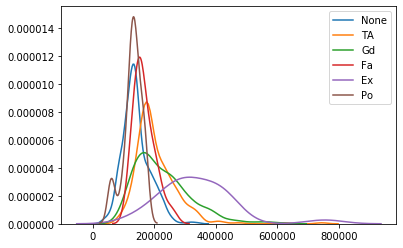

In [17]:
indexes = list(np.arange(43, 58))
X_floorspace = X.iloc[:, indexes]
common_descriptors(X_floorspace)
numerical_description(X_floorspace.select_dtypes(exclude = 'object'), y, numerical_test_stats)
categorical_description(X_floorspace.select_dtypes(include = 'object'), y, categorical_test_stats)

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


 Column BsmtFullBath analysis
count categories
   index  BsmtFullBath
0      0           856
1      1           588
2      2            15
3      3             1
Check for normality within data via Shapiro-Wilk
1: + (0.8769222497940063, 3.645355878952783e-21)
0: + (0.8727579116821289, 7.992347342734592e-26)
2: + (0.8663820028305054, 0.02986769936978817)
Check for equal variance between categories via Leven test
LeveneResult(statistic=10.117994815674475, pvalue=1.345596727660637e-06)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=73.97588751087922, pvalue=6.005945476684253e-16)


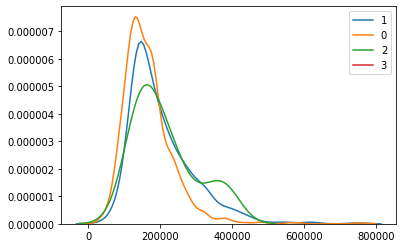

 Column FullBath analysis
count categories
   index  FullBath
0      2       768
1      1       650
2      3        33
3      0         9
Check for normality within data via Shapiro-Wilk
2: + (0.9295902848243713, 1.6129696242417847e-18)
1: + (0.8657883405685425, 3.715635522242472e-23)
3: + (0.8843562006950378, 0.002144074300304055)
0: + (0.9223263263702393, 0.41184866428375244)
Check for equal variance between categories via Leven test
LeveneResult(statistic=72.1815661180425, pvalue=1.600699360153946e-43)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=599.3641598807649, pvalue=1.3843139338847373e-129)


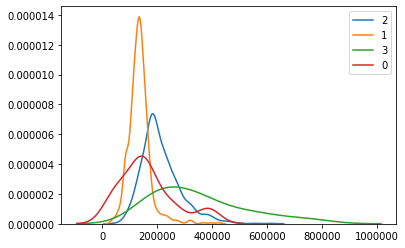

 Column HalfBath analysis
count categories
   index  HalfBath
0      0       913
1      1       535
2      2        12
Check for normality within data via Shapiro-Wilk
1: + (0.8386638760566711, 7.051964633149335e-23)
0: + (0.8925346732139587, 1.0150617408048662e-24)
2: + (0.9353643655776978, 0.44044631719589233)
Check for equal variance between categories via Leven test
LeveneResult(statistic=7.755982093653489, pvalue=0.0004460918223187736)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=179.3186567472938, pvalue=1.151989275905872e-39)


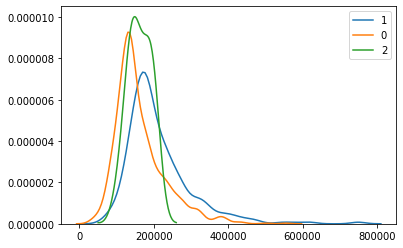

 Column BedroomAbvGr analysis
count categories
   index  BedroomAbvGr
0      3           804
1      2           358
2      4           213
3      1            50
4      5            21
5      6             7
6      0             6
7      8             1
Check for normality within data via Shapiro-Wilk
3: + (0.9212589263916016, 4.6561227661134195e-20)
4: + (0.8380740880966187, 3.794419612497199e-14)
1: + (0.9001585841178894, 0.00048631196841597557)
2: + (0.8240616917610168, 1.7702426373292282e-19)
0: + (0.9095938205718994, 0.4337298572063446)
5: + (0.950950562953949, 0.3549877107143402)
6: + (0.7698260545730591, 0.020347241312265396)
Check for equal variance between categories via Leven test
LeveneResult(statistic=8.261386115599802, pvalue=6.535457066252057e-10)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=101.08529238009643, pvalue=6.438083365177359e-19)


C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


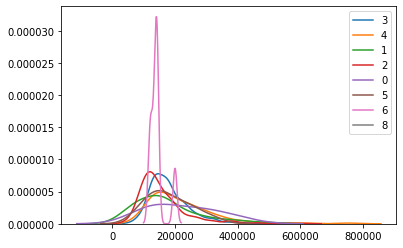

 Column KitchenAbvGr analysis
count categories
   index  KitchenAbvGr
0      1          1392
1      2            65
2      3             2
3      0             1
Check for normality within data via Shapiro-Wilk
1: + (0.8739009499549866, 4.1109241500163186e-32)
2: + (0.9676781296730042, 0.08696512132883072)
Check for equal variance between categories via Leven test
LeveneResult(statistic=6.942080662517015, pvalue=0.00012233827992496238)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=43.206477531436875, pvalue=2.224697315688999e-09)


C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


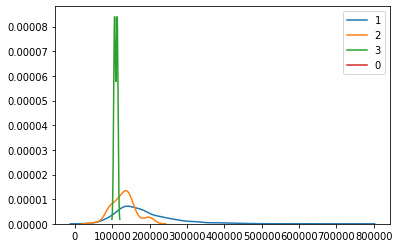

 Column KitchenQual analysis
count categories
  index  KitchenQual
0    TA          735
1    Gd          586
2    Ex          100
3    Fa           39
Check for normality within data via Shapiro-Wilk
Gd: + (0.9404856562614441, 1.4627472952506715e-14)
TA: + (0.9525182843208313, 1.2083440835647472e-14)
Ex: + (0.9487834572792053, 0.000690411077812314)
Fa: + (0.9658145308494568, 0.2770366072654724)
Check for equal variance between categories via Leven test
LeveneResult(statistic=75.90889354996212, pvalue=1.2792878591616223e-45)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=661.4815872916723, pvalue=4.720112898518107e-143)


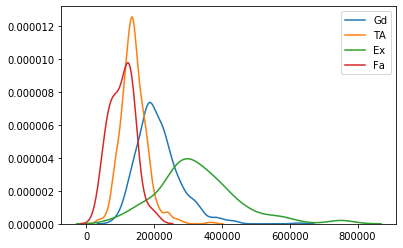

 Column TotRmsAbvGrd analysis
count categories
    index  TotRmsAbvGrd
0       6           402
1       7           329
2       5           275
3       8           187
4       4            97
5       9            75
6      10            47
7      11            18
8       3            17
9      12            11
10     14             1
11      2             1
Check for normality within data via Shapiro-Wilk
8: + (0.9493376016616821, 3.334883786010323e-06)
6: + (0.9514687061309814, 3.1983526938006435e-10)
7: + (0.9454501271247864, 1.1406331434926642e-09)
9: + (0.9773827791213989, 0.1990879774093628)
5: + (0.8500998020172119, 1.2219863750374013e-15)
11: + (0.964080810546875, 0.6818785071372986)
4: + (0.9566404223442078, 0.0028180484659969807)
10: + (0.899253249168396, 0.0006818104884587228)
12: + (0.7511945962905884, 0.0021545502822846174)
3: + (0.8618156313896179, 0.016324102878570557)
Check for equal variance between categories via Leven test
LeveneResult(statistic=22.348107261023085, pva

C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


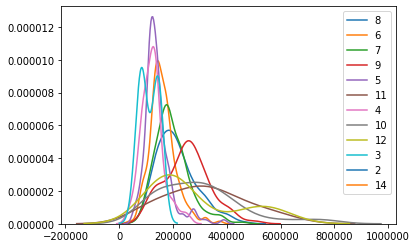

 Column Functional analysis
count categories
  index  Functional
0   Typ        1360
1  Min2          34
2  Min1          31
3   Mod          15
4  Maj1          14
5  Maj2           5
6   Sev           1
Check for normality within data via Shapiro-Wilk
Typ: + (0.873175323009491, 7.360058714361469e-32)
Min1: + (0.962878406047821, 0.346971720457077)
Maj1: + (0.8951513171195984, 0.09593456238508224)
Min2: + (0.8220970034599304, 7.065273530315608e-05)
Mod: + (0.7678675651550293, 0.001464420696720481)
Maj2: + (0.9302647709846497, 0.5981771349906921)
Check for equal variance between categories via Leven test
LeveneResult(statistic=3.2058295451467504, pvalue=0.003941556478703438)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=32.55981593513185, pvalue=1.2741797160986796e-05)


C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


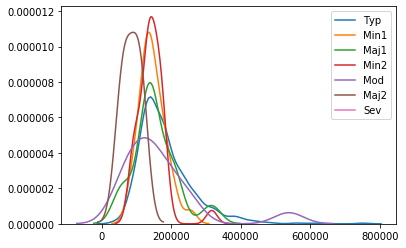

 Column Fireplaces analysis
count categories
   index  Fireplaces
0      0         690
1      1         650
2      2         115
3      3           5
Check for normality within data via Shapiro-Wilk
0: + (0.9651637673377991, 9.678919124511687e-12)
1: + (0.9108942747116089, 4.544349339607338e-19)
2: + (0.8028332591056824, 4.064941785952847e-11)
3: + (0.8330533504486084, 0.14661701023578644)
Check for equal variance between categories via Leven test
LeveneResult(statistic=43.79196440218186, pvalue=4.290692843716355e-27)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=406.8360963973842, pvalue=7.317749401601013e-88)


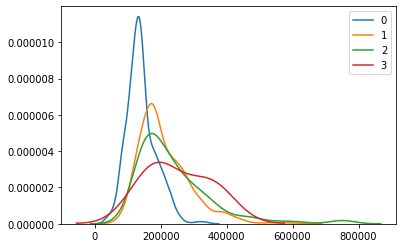

 Column FireplaceQu analysis
count categories
  index  FireplaceQu
0  None          690
1    Gd          380
2    TA          313
3    Fa           33
4    Ex           24
5    Po           20
Check for normality within data via Shapiro-Wilk
None: + (0.9651637673377991, 9.678919124511687e-12)
TA: + (0.8244742155075073, 3.75463525251444e-18)
Gd: + (0.9161105751991272, 1.0380400288249533e-13)
Fa: + (0.9357827305793762, 0.05127148702740669)
Ex: + (0.8817865252494812, 0.009029182605445385)
Po: + (0.9205381274223328, 0.10147710889577866)
Check for equal variance between categories via Leven test
LeveneResult(statistic=35.39241064192538, pvalue=2.9370412099482057e-34)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=461.8996248145718, pvalue=1.3311553329034221e-97)


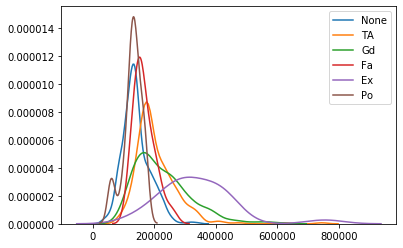

In [18]:
numerical_test_stats.pop('KitchenAbvGr', None)
numerical_test_stats.pop('BedroomAbvGr', None)
numerical_test_stats.pop('HalfBath', None)
numerical_test_stats.pop('FullBath', None)
numerical_test_stats.pop('BsmtFullBath', None)
numerical_test_stats.pop('BsmtHalfBath', None)
numerical_test_stats.pop('Fireplaces', None)
numerical_test_stats.pop('TotRmsAbvGrd', None)

lists = ['KitchenAbvGr', 'BedroomAbvGr', 'HalfBath', 'FullBath', 'BsmtFullBath', 'Fireplaces', 'TotRmsAbvGrd']
X[lists] = X[lists].astype('object')
X_floorspace = X.iloc[:, indexes]
categorical_description(X_floorspace.select_dtypes(include = 'object'), y, categorical_test_stats)

In [19]:
X_exterior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Condition1    1460 non-null   object 
 1   Condition2    1460 non-null   object 
 2   BldgType      1460 non-null   object 
 3   HouseStyle    1460 non-null   object 
 4   OverallQual   1460 non-null   object 
 5   OverallCond   1460 non-null   object 
 6   YearBuilt     1460 non-null   int64  
 7   YearRemodAdd  1460 non-null   int64  
 8   RoofStyle     1460 non-null   object 
 9   RoofMatl      1460 non-null   object 
 10  Exterior1st   1460 non-null   object 
 11  Exterior2nd   1460 non-null   object 
 12  MasVnrType    1452 non-null   object 
 13  MasVnrArea    1452 non-null   float64
 14  ExterQual     1460 non-null   object 
 15  ExterCond     1460 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory usage: 182.6+ KB


## House Garage [Return](#ToC)<a id='Garage'></a>

Head of dataframe
  GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual  \
0     Attchd       2003.0          RFn           2         548         TA   
1     Attchd       1976.0          RFn           2         460         TA   
2     Attchd       2001.0          RFn           2         608         TA   
3     Detchd       1998.0          Unf           3         642         TA   
4     Attchd       2000.0          RFn           3         836         TA   

  GarageCond PavedDrive  
0         TA          Y  
1         TA          Y  
2         TA          Y  
3         TA          Y  
4         TA          Y  

 Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GarageType    1379 non-null   object 
 1   GarageYrBlt   1379 non-null   float64
 2   GarageFinish  1379 non-null   object 
 3   GarageCars    1460 non-

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


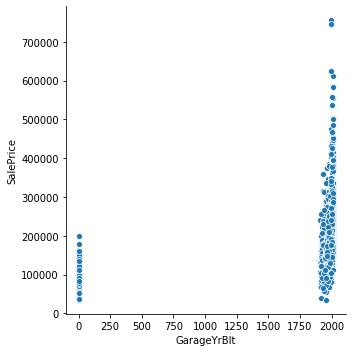

 Column GarageCars analysis
Check for strength of linear relation via Pearsons r test
(0.6404091972583521, 2.4986441671792262e-169)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.6907109670497434, pvalue=1.6545168265608803e-207)


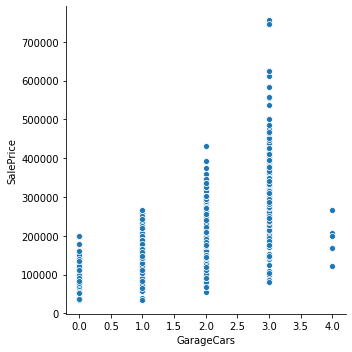

 Column GarageArea analysis
Check for strength of linear relation via Pearsons r test
(0.6234314389183616, 5.2650381679802e-158)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.6493785338868229, pvalue=1.320918093357304e-175)


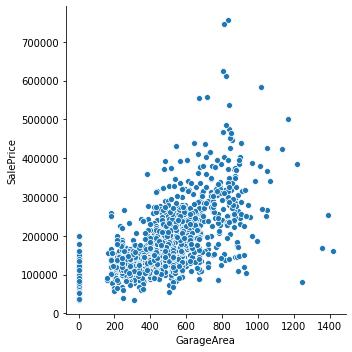

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


 Column GarageType analysis
count categories
     index  GarageType
0   Attchd         870
1   Detchd         387
2  BuiltIn          88
3     None          81
4  Basment          19
5  CarPort           9
6   2Types           6
Check for normality within data via Shapiro-Wilk
Attchd: + (0.8595801591873169, 3.7689100860697135e-27)
Detchd: + (0.8452333211898804, 4.624886745972798e-19)
BuiltIn: + (0.915790855884552, 2.700562254176475e-05)
CarPort: + (0.8726986646652222, 0.13140037655830383)
None: + (0.9727892875671387, 0.08193720132112503)
Basment: + (0.8750876784324646, 0.01765104942023754)
2Types: + (0.873970091342926, 0.24249395728111267)
Check for equal variance between categories via Leven test
LeveneResult(statistic=19.699313511271967, pvalue=3.2755438114875525e-22)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=532.6956152525266, pvalue=7.58134421720046e-112)


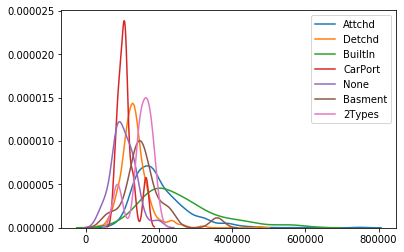

 Column GarageFinish analysis
count categories
  index  GarageFinish
0   Unf           605
1   RFn           422
2   Fin           352
3  None            81
Check for normality within data via Shapiro-Wilk
RFn: + (0.9047609567642212, 1.3273273098853271e-15)
Unf: + (0.8616032600402832, 1.1443193571941927e-22)
Fin: + (0.8658871650695801, 6.949015285882427e-17)
None: + (0.9727892875671387, 0.08193720132112503)
Check for equal variance between categories via Leven test
LeveneResult(statistic=50.60561997347511, pvalue=4.124459241335722e-31)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=609.8083796108044, pvalue=7.534250438595258e-132)


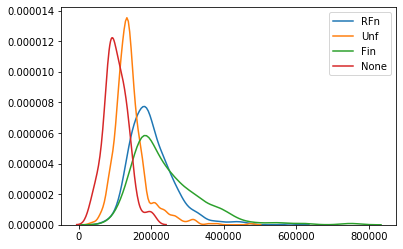

 Column GarageQual analysis
count categories
  index  GarageQual
0    TA        1311
1  None          81
2    Fa          48
3    Gd          14
4    Po           3
5    Ex           3
Check for normality within data via Shapiro-Wilk
TA: + (0.858399510383606, 9.193885884562695e-33)
Fa: + (0.8490527868270874, 2.052199124591425e-05)
Gd: + (0.9547068476676941, 0.6358537077903748)
None: + (0.9727892875671387, 0.08193720132112503)
Check for equal variance between categories via Leven test
LeveneResult(statistic=6.632161554157615, pvalue=4.08231931536644e-06)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=192.00130044449105, pvalue=1.458781905598995e-39)


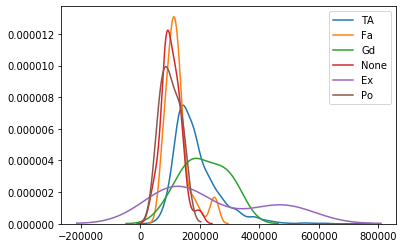

 Column GarageCond analysis
count categories
  index  GarageCond
0    TA        1326
1  None          81
2    Fa          35
3    Gd           9
4    Po           7
5    Ex           2
Check for normality within data via Shapiro-Wilk
TA: + (0.8592310547828674, 7.547405477512473e-33)
Fa: + (0.9778168201446533, 0.6870063543319702)
None: + (0.9727892875671387, 0.08193720132112503)
Gd: + (0.8049484491348267, 0.02325512282550335)
Po: + (0.9486566185951233, 0.7174552083015442)
Check for equal variance between categories via Leven test
LeveneResult(statistic=6.226255647936507, pvalue=1.0099526404852335e-05)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=190.96363814765215, pvalue=2.4312091116099177e-39)


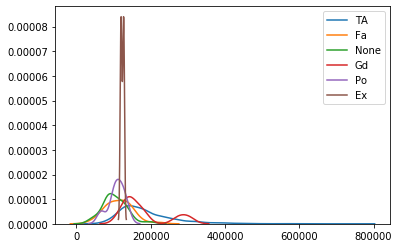

 Column PavedDrive analysis
count categories
  index  PavedDrive
0     Y        1340
1     N          90
2     P          30
Check for normality within data via Shapiro-Wilk
Y: + (0.8629826307296753, 1.1998783648253635e-32)
N: + (0.960116982460022, 0.007439893204718828)
P: + (0.9589770436286926, 0.291604608297348)
Check for equal variance between categories via Leven test
LeveneResult(statistic=9.278563040263395, pvalue=9.904149421246108e-05)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=115.83910247416952, pvalue=7.012267959594329e-26)


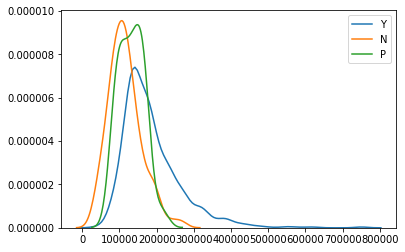

In [20]:
indexes = list(np.arange(58, 66))
X_garage = X.iloc[:, indexes]
common_descriptors(X_garage)
numerical_description(X_garage.select_dtypes(exclude = 'object'), y, numerical_test_stats)
categorical_description(X_garage.select_dtypes(include = 'object'), y, categorical_test_stats)

## House Porch [Return](#ToC)<a id='Porch'></a>

Head of dataframe
   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch
0           0           61              0          0            0
1         298            0              0          0            0
2           0           42              0          0            0
3           0           35            272          0            0
4         192           84              0          0            0

 Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   WoodDeckSF     1460 non-null   int64
 1   OpenPorchSF    1460 non-null   int64
 2   EnclosedPorch  1460 non-null   int64
 3   3SsnPorch      1460 non-null   int64
 4   ScreenPorch    1460 non-null   int64
dtypes: int64(5)
memory usage: 57.2 KB
None

 Numeric Statistics
        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch
count  1460.000000  1460.000000   

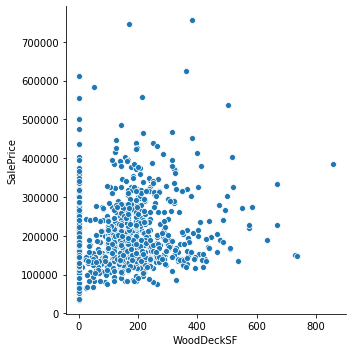

 Column OpenPorchSF analysis
Check for strength of linear relation via Pearsons r test
(0.3158562271160553, 3.493373623097777e-35)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.47756066228252647, pvalue=4.860098096441017e-84)


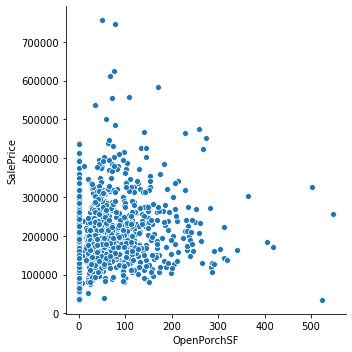

 Column EnclosedPorch analysis
Check for strength of linear relation via Pearsons r test
(-0.12857795792595675, 8.255770475119532e-07)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=-0.2183936205521982, pvalue=3.180474171341711e-17)


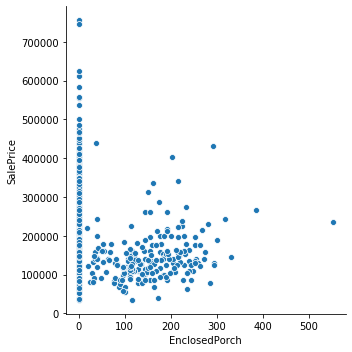

 Column 3SsnPorch analysis
Check for strength of linear relation via Pearsons r test
(0.04458366533574841, 0.08858170358062883)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.06544021620062833, pvalue=0.012384087320432495)


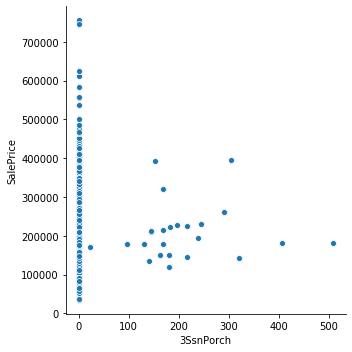

 Column ScreenPorch analysis
Check for strength of linear relation via Pearsons r test
(0.1114465711429112, 1.9721400194702135e-05)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=0.1000697202012266, pvalue=0.0001281428771122835)


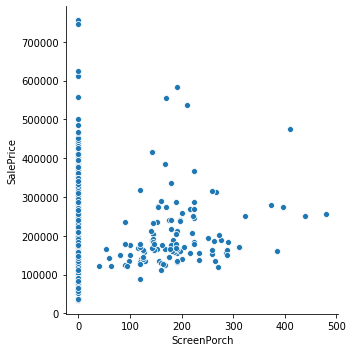

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [21]:
indexes = list(np.arange(66, 71))
X_porch = X.iloc[:, indexes]
common_descriptors(X_porch)
numerical_description(X_porch.select_dtypes(exclude = 'object'), y, numerical_test_stats)
categorical_description(X_porch.select_dtypes(include = 'object'), y, categorical_test_stats)

## House Misc [Return](#ToC)<a id='Misc'></a>

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Head of dataframe
   PoolArea PoolQC Fence MiscFeature  MiscVal
0         0    NaN   NaN         NaN        0
1         0    NaN   NaN         NaN        0
2         0    NaN   NaN         NaN        0
3         0    NaN   NaN         NaN        0
4         0    NaN   NaN         NaN        0

 Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PoolArea     1460 non-null   int64 
 1   PoolQC       7 non-null      object
 2   Fence        281 non-null    object
 3   MiscFeature  54 non-null     object
 4   MiscVal      1460 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 57.2+ KB
None

 Numeric Statistics
          PoolArea       MiscVal
count  1460.000000   1460.000000
mean      2.758904     43.489041
std      40.177307    496.123024
min       0.000000      0.000000
25%       0.000000      0.000000
50%       0.000000      

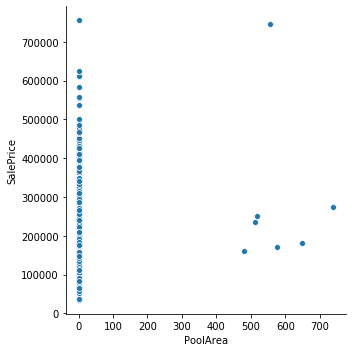

 Column MiscVal analysis
Check for strength of linear relation via Pearsons r test
(-0.02118957964030326, 0.4184863494082891)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=-0.0627270024962966, pvalue=0.016525262189967624)


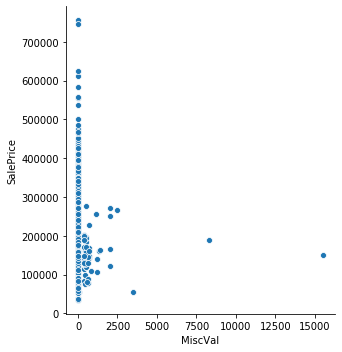

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


 Column PoolQC analysis
count categories
  index  PoolQC
0  None    1453
1    Gd       3
2    Ex       2
3    Fa       2
Check for normality within data via Shapiro-Wilk
None: + (0.8797449469566345, 4.185271522843539e-32)
Check for equal variance between categories via Leven test
LeveneResult(statistic=8.075383073365899, pvalue=2.456263512602958e-05)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=5.995693231359807, pvalue=0.11181994685528329)


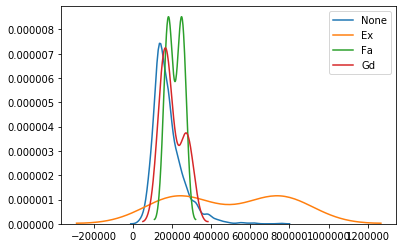

 Column Fence analysis
count categories
   index  Fence
0   None   1179
1  MnPrv    157
2  GdPrv     59
3   GdWo     54
4   MnWw     11
Check for normality within data via Shapiro-Wilk
None: + (0.8938281536102295, 9.486915201897752e-28)
MnPrv: + (0.6216445565223694, 1.819016695913564e-18)
GdWo: + (0.8134628534317017, 8.651643383927876e-07)
GdPrv: + (0.7754843235015869, 4.201181980079127e-08)
MnWw: + (0.8878175020217896, 0.1305905133485794)
Check for equal variance between categories via Leven test
LeveneResult(statistic=11.20691503928037, pvalue=5.8830750011685725e-09)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=78.02324179296481, pvalue=4.56724658607468e-16)


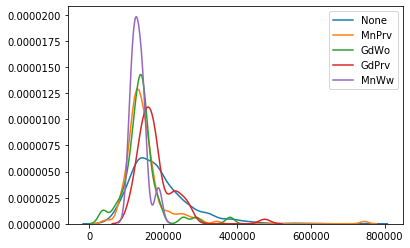

 Column MiscFeature analysis
count categories
  index  MiscFeature
0  None         1406
1  Shed           49
2  Othr            2
3  Gar2            2
4  TenC            1
Check for normality within data via Shapiro-Wilk
None: + (0.8688992857933044, 9.296471276558956e-33)
Shed: + (0.9558219313621521, 0.063783660531044)
Check for equal variance between categories via Leven test
LeveneResult(statistic=1.4049277537299463, pvalue=0.2299959677519955)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=11.603011207972314, pvalue=0.020560950601935787)


C:\Users\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


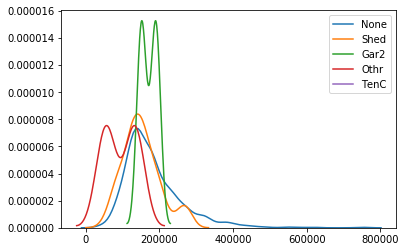

In [22]:
indexes = list(np.arange(71, 76))
X_misc = X.iloc[:, indexes]
common_descriptors(X_misc)
numerical_description(X_misc.select_dtypes(exclude = 'object'), y, numerical_test_stats)
categorical_description(X_misc.select_dtypes(include = 'object'), y, categorical_test_stats)

## House Sold [Return](#ToC)<a id='Sold'></a>

Head of dataframe
   MoSold  YrSold SaleType SaleCondition
0       2    2008       WD        Normal
1       5    2007       WD        Normal
2       9    2008       WD        Normal
3       2    2006       WD       Abnorml
4      12    2008       WD        Normal

 Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MoSold         1460 non-null   int64 
 1   YrSold         1460 non-null   int64 
 2   SaleType       1460 non-null   object
 3   SaleCondition  1460 non-null   object
dtypes: int64(2), object(2)
memory usage: 45.8+ KB
None

 Numeric Statistics
            MoSold       YrSold
count  1460.000000  1460.000000
mean      6.321918  2007.815753
std       2.703626     1.328095
min       1.000000  2006.000000
25%       5.000000  2007.000000
50%       6.000000  2008.000000
75%       8.000000  2009.000000
max      12.000000  2010.

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


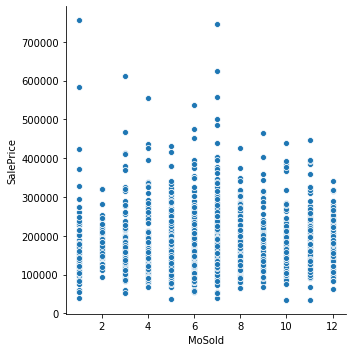

 Column YrSold analysis
Check for strength of linear relation via Pearsons r test
(-0.028922585168730326, 0.26941319328103863)
Check for strength of monoiticity via Spearman rank test
SpearmanrResult(correlation=-0.029899134912615286, pvalue=0.25356997604498915)


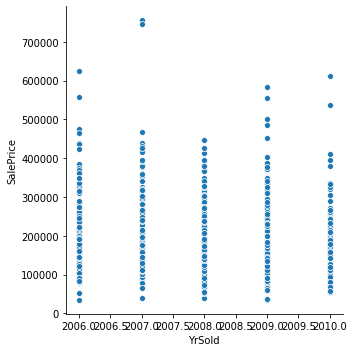

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


 Column SaleType analysis
count categories
   index  SaleType
0     WD      1267
1    New       122
2    COD        43
3  ConLD         9
4  ConLw         5
5  ConLI         5
6    CWD         4
7    Oth         3
8    Con         2
Check for normality within data via Shapiro-Wilk
WD: + (0.8731486797332764, 7.03094345336994e-31)
New: + (0.9221402406692505, 2.7178200525668217e-06)
COD: + (0.9348729848861694, 0.017141791060566902)
ConLD: + (0.9204258322715759, 0.39577776193618774)
ConLI: + (0.7272393107414246, 0.018068356439471245)
CWD: + (0.9101431965827942, 0.483161062002182)
ConLw: + (0.9070736169815063, 0.4502060115337372)
Check for equal variance between categories via Leven test
LeveneResult(statistic=5.734204014027636, pvalue=3.2901348871158974e-07)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=156.38287687755164, pvalue=9.119744067696711e-30)


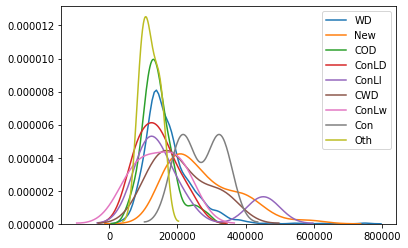

 Column SaleCondition analysis
count categories
     index  SaleCondition
0   Normal           1198
1  Partial            125
2  Abnorml            101
3   Family             20
4   Alloca             12
5  AdjLand              4
Check for normality within data via Shapiro-Wilk
Normal: + (0.8855304718017578, 7.375035156561849e-29)
Abnorml: + (0.6921567320823669, 3.017388314034697e-13)
Partial: + (0.925574004650116, 3.4288750612176955e-06)
AdjLand: + (0.7528108954429626, 0.04102310910820961)
Alloca: + (0.9242622256278992, 0.323228657245636)
Family: + (0.932625949382782, 0.17345093190670013)
Check for equal variance between categories via Leven test
LeveneResult(statistic=8.540862623617812, pvalue=5.537686063895505e-08)
Calculate Kruskal Wallis test statistic
KruskalResult(statistic=168.3225408748744, pvalue=1.6633131687538264e-34)


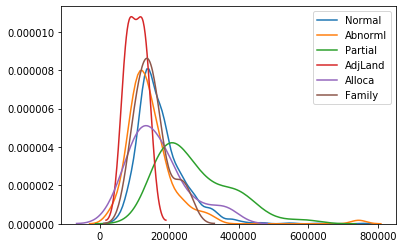

In [23]:
indexes = list(np.arange(76, 80))
X_sold = X.iloc[:, indexes]
common_descriptors(X_sold)
numerical_description(X_sold.select_dtypes(exclude = 'object'), y, numerical_test_stats)
categorical_description(X_sold.select_dtypes(include = 'object'), y, categorical_test_stats)

## Feature Selection [Return](#ToC)<a id='Reduce'></a>

# Order and rank columns statistical importance

In [24]:
categorical_test_stats = {k: v for k, v in sorted(categorical_test_stats.items(), key=lambda item: item[1])}

In [25]:
categorical_test_stats

{'OverallQual': 3.5069726379167716e-202,
 'Neighborhood': 6.696799031735812e-168,
 'ExterQual': 8.180798192071324e-148,
 'BsmtQual': 1.209826097695688e-144,
 'KitchenQual': 4.720112898518107e-143,
 'GarageFinish': 7.534250438595258e-132,
 'FullBath': 1.3843139338847373e-129,
 'GarageType': 7.58134421720046e-112,
 'MSSubClass': 1.8968600448434124e-104,
 'Foundation': 2.169096402016262e-103,
 'FireplaceQu': 1.3311553329034221e-97,
 'Fireplaces': 7.317749401601013e-88,
 'TotRmsAbvGrd': 4.624422308033079e-83,
 'HeatingQC': 6.036448505067046e-76,
 'BsmtFinType1': 2.6868703907040177e-72,
 'MasVnrType': 2.0587312313534828e-58,
 'MSZoning': 3.0807239995999556e-57,
 'Exterior1st': 1.694485653395439e-56,
 'Exterior2nd': 1.0476359663623384e-51,
 'OverallCond': 4.133949890533891e-47,
 'BsmtExposure': 3.184260345613763e-40,
 'HalfBath': 1.151989275905872e-39,
 'GarageQual': 1.458781905598995e-39,
 'GarageCond': 2.4312091116099177e-39,
 'HouseStyle': 1.3885066980297387e-36,
 'SaleCondition': 1.66331

In [26]:
numerical_test_stats = {k: v for k, v in sorted(numerical_test_stats.items(), key=lambda item: item[1])}

In [27]:
numerical_test_stats

{'EnclosedPorch': -0.12857795792595675,
 'YrSold': -0.028922585168730326,
 'LowQualFinSF': -0.02560613000067956,
 'MiscVal': -0.02118957964030326,
 'BsmtFinSF2': -0.011378121450215141,
 '3SsnPorch': 0.04458366533574841,
 'MoSold': 0.04643224522381934,
 'PoolArea': 0.0924035494918732,
 'ScreenPorch': 0.1114465711429112,
 'LotFrontage': 0.2096239447994839,
 'BsmtUnfSF': 0.21447910554696892,
 'GarageYrBlt': 0.2613664351029631,
 'LotArea': 0.2638433538714057,
 'OpenPorchSF': 0.3158562271160553,
 '2ndFlrSF': 0.3193338028320678,
 'WoodDeckSF': 0.3244134445681299,
 'BsmtFinSF1': 0.38641980624215333,
 'MasVnrArea': 0.47261449900457375,
 'YearRemodAdd': 0.5071009671113862,
 'YearBuilt': 0.5228973328794968,
 '1stFlrSF': 0.6058521846919146,
 'TotalBsmtSF': 0.6135805515591954,
 'GarageArea': 0.6234314389183616,
 'GarageCars': 0.6404091972583521,
 'GrLivArea': 0.708624477612652}

The results of the statistical tests seem to align with general expectations of what people look for in a house, such as how much living area there is, the neighbourhood it is in, the general quality of the house etc. The ordering of these lists should therefore serve as a starting point for introducing features into a ML model.

# Take Most statistically significant columns per data type and export to csv

In [28]:
numerical_columns = [k for k in list(numerical_test_stats)[-7:]]

In [29]:
categorical_columns = [k for k in list(categorical_test_stats)[:14]]

In [30]:
features = numerical_columns + categorical_columns

In [31]:
X_features = X.loc[:, features]
X_features['SalePrice'] = y

In [32]:
X_features.to_csv('../data/data_features.csv', index = False)